# Problem_A_PART_1 
 - Basic CNN and its varient
 - Image Data augmentation 

In [1]:
!nvidia-smi

Thu Apr 29 23:15:16 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 461.33       Driver Version: 461.33       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro T2000 wi... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   45C    P8     6W /  N/A |    132MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

* Developed this Notebook on Local system. GoogleCollable kept running out of memory

In [2]:
# import the necessary packages
import gc
import h5py
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tensorflow import keras
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.layers import Activation
from IPython.display import display
from keras.utils import plot_model
from matplotlib.pyplot import draw, show

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [3]:
#Read data from hdf5 file(code provided with assignment)

def loadDataH5():        
    
    with h5py.File('./earth_data.h5','r') as hf:
        trainX = np.array(hf.get('trainX'))
        trainY = np.array(hf.get('trainY'))
        valX = np.array(hf.get('valX'))
        valY = np.array(hf.get('valY'))        
    return trainX, trainY, valX, valY

#### Get All details about data
    - Training & Validation
    - Image Dimesnion 
    - Classes

In [4]:

def get_working_data():
  trainX, trainY, valX, valY = loadDataH5()
  training_data_count,height,width,depth = trainX.shape
  unique_val, class_dist = np.unique(trainY,return_counts=True)
  print("Number of classes:",unique_val.shape[0])
  print("Class Value:",unique_val)
  print("Class distribution:",class_dist)
  print(trainX.shape,trainY.shape)
  print(valX.shape,valY.shape)
  trainX = trainX.astype("float") / 255.0
  valX = valX.astype("float") / 255.0
  return trainX, trainY, valX, valY,(height,width,depth,unique_val.shape[0])

g_trainX,g_trainY,g_valX,g_valY,(g_height,g_width,g_depth,g_classes) = \
                        get_working_data()

Number of classes: 9
Class Value: [0 1 2 3 4 5 6 7 8]
Class distribution: [2400 2400 2400 2000 2000 1600 2000 2400 2000]
(19200, 64, 64, 3) (19200,)
(4800, 64, 64, 3) (4800,)


`As per number of instances for each class displayed above, the data set has class imbalance problem `

---

In [88]:
#Stores the performance matrix for each model run
class MODEL_PERFORMANCE:

  def __init__(self, val_loss,val_acc,train_loss,train_acc):
    self.val_loss = val_loss
    self.val_acc  = val_acc
    self.train_loss = train_loss
    self.train_acc = train_acc
    
# For each model, performance matrix is stored as key-value 
# pair, with key as model name
# Value is MODEL_PERFORMANCE object

class RECORD:

  # Initialise the dictionary
  def __init__(self):
    self.store = {}    
  
  # Add an entry to the dictionary
  def add_entry(self,name,performance):
    self.store[name] = performance



In [6]:
#

#Stores performances of model

g_record_v1 = RECORD() # Stores performance of model without augmentaion 
g_record_v2 = RECORD() # Stores performance of model with varying learning rate
g_record_v3 = RECORD() # Stores performance of model with augmentaion 

# PLOTS

-  Sigle plot produced at the end of execution of each model depicting validation/training loss/accuracy 

In [8]:
# Performance plot for a model depicting training/validation loss/accuracy

def plot_model_performance(name,history,model_history):
  plt.style.use("ggplot")
  plt.figure(figsize=(7,6))
                    
  epoch_ran = len(history.history["loss"])
  plt.plot(np.arange(0, epoch_ran), \
           history.history["loss"], label="train_loss")
  plt.plot(np.arange(0, epoch_ran), \
           history.history["val_loss"], label="val_loss")
  plt.plot(np.arange(0, epoch_ran), \
           history.history["accuracy"], label="train_acc")
  plt.plot(np.arange(0, epoch_ran), \
           history.history["val_accuracy"], label="val_acc")
  plt.title("Training Loss and Accuracy")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Accuracy")
  plt.legend()
  plt.show()

  #Print best score 
  print("\nModel Performance Summary:\n")
  
  
  min_val_loss = min(history.history["val_loss"])

  epoch_index = history.history["val_loss"].index(min_val_loss)
    
  best_val_accuracy = history.history["val_accuracy"][epoch_index]

  print("Min validation loss:",min_val_loss," at EPOCH:", epoch_index+1)

  print("\nValidation Accuracy: ",best_val_accuracy)
  
  #Store the above performance matrix
  model_history.add_entry(name,MODEL_PERFORMANCE( \
                             val_acc = history.history["val_accuracy"], \
                            val_loss = history.history["val_loss"], \
                            train_loss = history.history["loss"],
                            train_acc = history.history["accuracy"]))

In [9]:
# Plot comparative model performance
# Takes input as two model name
#
#

# Wrapper function 
def compare_model_performance_with_lrs(model_name):
    
    compare_model_performance(model_name, model_name, model_name,\
                              model2_history = g_record_v2)
    
def compare_model_performance_with_augmentation(model_name):

    compare_model_performance(model_name, model_name, \
                              "Augmented " + model_name,\
                              model2_history = g_record_v3) 
    
    
def compare_model_performance_with_another(model1_name,model2_name):
    compare_model_performance(model1_name, model2_name, \
                      " 1: " + model1_name+" 2:"+model2_name,\
                              model2_history = g_record_v1)    

    
# Actual implementations
# Display two subplots:
# One for loss
# one for accuracy 
def compare_model_performance(model1_name,model2_name,title_suffix,\
                              model1_history = \
                              g_record_v1,model2_history = g_record_v1):
  
  # Get the model data from store
  mode1_per = model1_history.store[model1_name]
  mode2_per = model2_history.store[model2_name]

  model1_val_loss = mode1_per.val_loss
  model1_val_acc = mode1_per.val_acc
  model1_train_loss = mode1_per.train_loss
  model1_train_acc = mode1_per.train_acc
  
  model2_val_loss = mode2_per.val_loss
  model2_val_acc = mode2_per.val_acc
  model2_train_loss = mode2_per.train_loss
  model2_train_acc = mode2_per.train_acc

  #Plot the model data
  plt.style.use("ggplot")
  
  fig, axes = plt.subplots(1,2,figsize=(12,5))
 
  epoch1_ran = len(model1_val_loss)
  epoch2_ran = len(model2_val_loss)

  plt.subplots_adjust(wspace=0.5, hspace=0.5)
    
  axes[0].set_xlabel("EPOCH #")
  axes[0].set_ylabel("Loss")
  axes[0].set(title = title_suffix)
  axes[0].plot(np.arange(0,epoch1_ran),model1_val_loss,label="1: Val Loss")
  axes[0].plot(np.arange(0,epoch2_ran),model2_val_loss,label="2: Val Loss")
  axes[0].plot(np.arange(0,epoch1_ran),model1_train_loss,label="1: Train Loss")
  axes[0].plot(np.arange(0,epoch2_ran),model2_train_loss,label="2: Train Loss")
  axes[0].legend()
    
  axes[1].set_xlabel("EPOCH #")
  axes[1].set_ylabel("Accuracy")
  axes[1].set(title = title_suffix)
  axes[1].plot(np.arange(0,epoch1_ran),model1_val_acc,label="1: Val Acc")
  axes[1].plot(np.arange(0,epoch2_ran),model2_val_acc,label="2: Val Acc")
  axes[1].plot(np.arange(0,epoch1_ran),model1_train_acc,label="1: Train Acc")
  axes[1].plot(np.arange(0,epoch2_ran),model2_train_acc,label="2: Train Acc")
  axes[1].legend()
    
  fig.tight_layout()
  draw()
  plt.show()

#### Summarize the model perfromance 

In [94]:
# Wrapper function
def model_perfromance_summary_with_augmentation():
    model_perfromance_summary(g_record_v3)
    
def model_perfromance_summary_with_varying_learning_rate():
    model_perfromance_summary(g_record_v2)
    
#Actual Implementation
def model_perfromance_summary(store_obj = g_record_v1):
    data = []
    for item in store_obj.store:
        perf = store_obj.store[item]   
        v_acc = max(perf.val_acc)
        print(item,":",v_acc)
        data.append([item,v_acc])

    df = pd.DataFrame(data, columns = ['Model', 'Val Acc'])
    display(df)
    plt.figure()
    plot = sns.barplot(y='Model', x='Val Acc', data=df)
    plt.show()

#### Utility function for executing model
     - CNN Model with given dataset
     - CNN Model with augmented dataset

In [74]:
# This function used for building,compiling and testing the model
def call_model(model_name,callback_obj,input_data = (g_trainX,g_trainY, \
                                                     g_valX,g_valY),\
               inputshape = (g_height,g_width,g_depth), \
               classes = g_classes, iterations = 70,optimizer_obj=None, \
               model_history = g_record_v1):
    
  NUM_EPOCHS = iterations

  trainX,trainY,valX,valY = input_data
    
  model = model_name(inputshape,classes)
  tf.random.set_seed(207241)

  if optimizer_obj==None:
    optimizer_obj = keras.optimizers.SGD(learning_rate=0.01)

  model.compile(optimizer=optimizer_obj, loss='sparse_categorical_crossentropy', \
                metrics=['accuracy'])
  print(model.summary())
  #Plot Model
  plots = plot_model(model,show_shapes=True,expand_nested=True)
  display(plots)
  
  history = model.fit(trainX, trainY, epochs = NUM_EPOCHS,  validation_data= \
                    (valX, valY), callbacks = callback_obj)  
  
  plot_model_performance(model.name,history,model_history)  
  #Invoking garbage collection manually helps allivaiting the problem of 
  # high RAM usage in
  gc.collect()

In [75]:
#This function use generator object 
def call_model_with_augmentation(model_name,callback_obj,generator_obj,
               input_data = (g_trainX,g_trainY, g_valX,g_valY),\
               inputshape = (g_height,g_width,g_depth), \
               classes = g_classes, iterations = 70,optimizer_obj=None, \
               model_history = g_record_v3, batch_size = 32):
    
  NUM_EPOCHS = iterations
  trainX,trainY,valX,valY = input_data
  model = model_name(inputshape,classes)

  tf.random.set_seed(207241)

  if optimizer_obj==None:
    optimizer_obj = keras.optimizers.SGD(learning_rate = 0.01)
  
  model.compile(optimizer=optimizer_obj, loss='sparse_categorical_crossentropy', \
                metrics=['accuracy'])
  print(model.summary())
  #Plot Model
  plots = plot_model(model,show_shapes=True,expand_nested=True)
  display(plots)
  
  history = model.fit(generator_obj, epochs = NUM_EPOCHS,  validation_data= \
                    (valX, valY), callbacks = callback_obj, \
                    steps_per_epoch=len(trainX)/ batch_size)  
  
  #Plot the model performance and store it
  plot_model_performance(model.name,history,model_history)  
  gc.collect()

# **Callbacks**


1.   Early Stopping on Minimum Validation Loss
2.   Checkpointing on Minimum Validation Loss
3.   Learning Rate Schedular

In [12]:
def get_early_stoping_cb_on_min_val_loss(patience_num = 2):
  return EarlyStopping(monitor='val_loss', mode='min', verbose=2, \
                       patience=patience_num)

def get_model_checkpoint_cb_on_min_val_loss(file_name):
  return ModelCheckpoint(file_name, monitor="val_loss", 	mode="min", \
                         save_best_only=True, verbose=1)	

def learning_rate_schedular_fun(epoch, lr):
  if epoch <10:
    return lr 
  else:
    return lr*tf.math.exp(-.1)
  
def get_model_learning_rate_cb():
  return tf.keras.callbacks.LearningRateScheduler(learning_rate_schedular_fun,\
                                                  verbose=1)


def get_basic_callback():
  return [get_early_stoping_cb_on_min_val_loss()]

def get_basic_and_lrs_callback():
  return [get_early_stoping_cb_on_min_val_loss(),get_model_learning_rate_cb()]

def get_all_callback(file_name):
  return [get_early_stoping_cb_on_min_val_loss(),\
          get_model_checkpoint_cb_on_min_val_loss(file_name),
          get_model_learning_rate_cb()]

# CNN MODEL
 - baseline
 - model_1
 - model_2
 - model_3
 - model_4
 - model_5
 - model_6

In [13]:
#Base Model
class MODEL:
    
    # 1 CONV (64,(3,3),"SAME"),MAXPOOLING,Fully Connected Layer,Softmax Layer
    @staticmethod
    def baseLine_cnn(inputshape, classes):

      model = \
      keras.Sequential( name = "baseLine_cnn", layers= \
          [
            tf.keras.layers.Conv2D (64, (3, 3), padding="same", \
                                        input_shape=inputshape, activation='relu'),
            keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Flatten(),   
            keras.layers.Dense(512,activation='relu'),
            tf.keras.layers.Dense(classes, activation='softmax')
          ])

      return model
    
    # 1 CONV (64,(3,3),"SAME"),MAXPOOLING,
    # 1 CONV (128,(3,3),"SAME"),MAXPOOLING,
    # Fully Connected Layer,Softmax Layer
    @staticmethod
    def model_1(inputshape, classes):

      model = \
      keras.Sequential( name = "model_1", layers= \
          [
            tf.keras.layers.Conv2D (64, (3, 3), padding="same", \
                                        input_shape=inputshape, activation='relu'),
            keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Conv2D (128, (3, 3), padding="same", activation='relu'),
            keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Flatten(),   
            keras.layers.Dense(512,activation='relu'),
            tf.keras.layers.Dense(classes, activation='softmax')
          ])

      return model
    
    
    # 1 CONV (64,(3,3),"SAME"),MAXPOOLING,
    # 1 CONV (128,(3,3),"SAME"),MAXPOOLING,
    # 1 CONV (256,(3,3),"SAME"),MAXPOOLING,
    # Fully Connected Layer,Softmax Layer
    @staticmethod
    def model_2(inputshape, classes):

      model = \
      keras.Sequential( name = "model_2", layers= \
          [
            tf.keras.layers.Conv2D (64, (3, 3), padding="same", \
                                        input_shape=inputshape, activation='relu'),
            keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Conv2D (128, (3, 3), padding="same", activation='relu'),
            keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Conv2D (256, (3, 3), padding="same", activation='relu'),
            keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Flatten(),   
            keras.layers.Dense(512,activation='relu'),
            tf.keras.layers.Dense(classes, activation='softmax')
          ])

      return model
    
    # 1 CONV (64,(3,3),"SAME"),MAXPOOLING,
    # 1 CONV (128,(3,3),"SAME"),MAXPOOLING,
    # 1 CONV (256,(3,3),"SAME"),MAXPOOLING,
    # dropout layer
    # Fully Connected Layer,Softmax Layer
    @staticmethod
    def model_3(inputshape, classes):

      model = \
      keras.Sequential( name = "model_3", layers= \
          [
            tf.keras.layers.Conv2D (64, (3, 3), padding="same", \
                                        input_shape=inputshape, activation='relu'),
            keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Conv2D (128, (3, 3), padding="same", activation='relu'),
            keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Conv2D (256, (3, 3), padding="same", activation='relu'),
            keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Flatten(),   
            keras.layers.Dropout(0.2),
            keras.layers.Dense(512,activation='relu'),          
            tf.keras.layers.Dense(classes, activation='softmax')
          ])

      return model
    
    
    # 1 CONV (32,(3,3),"SAME"),MAXPOOLING,
    # 1 CONV (64,(3,3),"SAME"),MAXPOOLING,
    # 1 CONV (128,(3,3),"SAME"),MAXPOOLING,
    # dropout layer
    # Fully Connected Layer,Softmax Layer
    @staticmethod
    def model_4(inputshape, classes):

      model = \
      keras.Sequential( name = "model_4", layers= \
          [
            tf.keras.layers.Conv2D (32, (3, 3), padding="same", \
                                        input_shape=inputshape, activation='relu'),
            keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Conv2D (64, (3, 3), padding="same", activation='relu'),
            keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Conv2D (128, (3, 3), padding="same", activation='relu'),
            keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Flatten(),   
            keras.layers.Dropout(0.2),
            keras.layers.Dense(512,activation='relu'),          
            tf.keras.layers.Dense(classes, activation='softmax')
          ])

      return model
    
    
    # 1 CONV (64,(3,3),"SAME"),MAXPOOLING,SpatialDropout
    # 1 CONV (128,(3,3),"SAME"),MAXPOOLING,SpatialDropout
    # 1 CONV (256,(3,3),"SAME"),MAXPOOLING,    
    # Fully Connected Layer,Softmax Layer
    @staticmethod
    def model_5(inputshape, classes):

      model = \
      keras.Sequential( name = "model_5", layers= \
          [
            tf.keras.layers.Conv2D (64, (3, 3), padding="same", \
                                        input_shape=inputshape, activation='relu'),
            keras.layers.MaxPooling2D(pool_size=(2, 2)),
            keras.layers.SpatialDropout2D(0.2),         
            tf.keras.layers.Conv2D (128, (3, 3), padding="same", activation='relu'),
            keras.layers.MaxPooling2D(pool_size=(2, 2)),
            keras.layers.SpatialDropout2D(0.2),
            tf.keras.layers.Flatten(),               
            keras.layers.Dense(512,activation='relu'),          
            tf.keras.layers.Dense(classes, activation='softmax')
          ])

      return model
    
    # 1 CONV (32,(3,3),"SAME"),MAXPOOLING,Fully Connected Layer,Softmax Layer
    @staticmethod
    def model_6(inputshape, classes):

      model = \
      keras.Sequential( name = "model_6", layers= \
          [
            tf.keras.layers.Conv2D (32, (3, 3), padding="same", \
                                        input_shape=inputshape, activation='relu'),
            keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Flatten(),   
            keras.layers.Dense(512,activation='relu'),
            tf.keras.layers.Dense(classes, activation='softmax')
          ])

      return model

#### Train & test the model

Model: "baseLine_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 64)        1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               33554944  
_________________________________________________________________
dense_3 (Dense)              (None, 9)                 4617      
Total params: 33,561,353
Trainable params: 33,561,353
Non-trainable params: 0
_________________________________________________________________
None


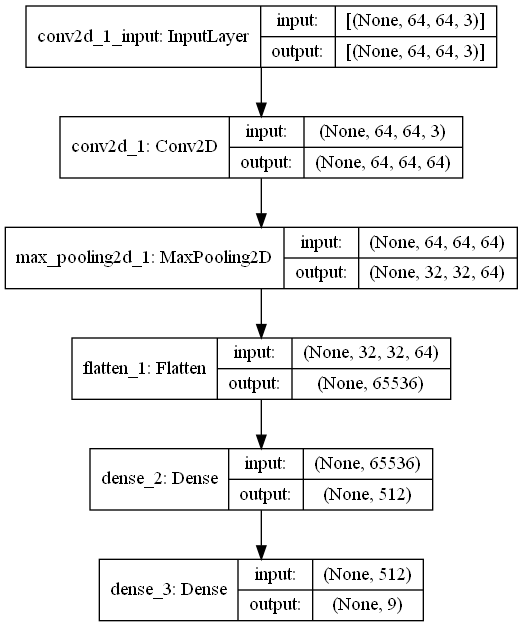

Epoch 1/70
600/600 [==============================] - 9s 14ms/step - loss: 1.8397 - accuracy: 0.3073 - val_loss: 1.5641 - val_accuracy: 0.3856
Epoch 2/70
600/600 [==============================] - 8s 14ms/step - loss: 1.4489 - accuracy: 0.4608 - val_loss: 1.4101 - val_accuracy: 0.4646
Epoch 3/70
600/600 [==============================] - 8s 14ms/step - loss: 1.3189 - accuracy: 0.5184 - val_loss: 1.1484 - val_accuracy: 0.5806s - loss: 1.3190 - accuracy: 0.51
Epoch 4/70
600/600 [==============================] - 8s 14ms/step - loss: 1.1504 - accuracy: 0.5852 - val_loss: 1.0249 - val_accuracy: 0.6577
Epoch 5/70
600/600 [==============================] - 8s 14ms/step - loss: 1.0626 - accuracy: 0.6143 - val_loss: 1.1434 - val_accuracy: 0.5704
Epoch 6/70
600/600 [==============================] - 8s 14ms/step - loss: 0.9671 - accuracy: 0.6477 - val_loss: 0.8849 - val_accuracy: 0.6785
Epoch 7/70
600/600 [==============================] - 8s 14ms/step - loss: 0.8791 - accuracy: 0.6790 - val_lo

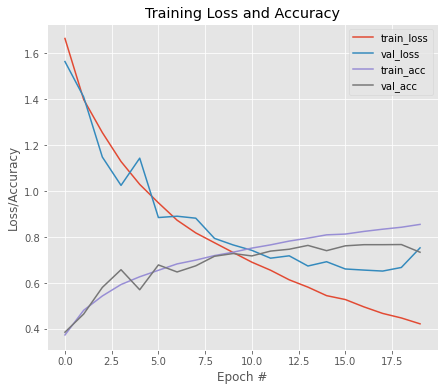


Model Performance Summary:

Min validation loss: 0.65178382396698  at EPOCH: 18

Validation Accuracy:  0.7666666507720947


In [15]:
call_model(MODEL.baseLine_cnn,get_basic_callback())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 64, 64, 64)        1792      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               16777728  
_________________________________________________________________
dense_5 (Dense)              (None, 9)                 4617

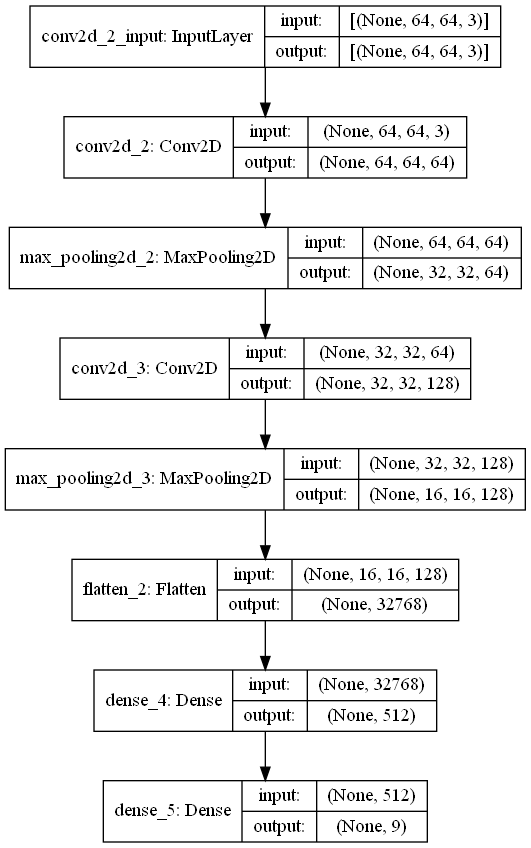

Epoch 1/70
600/600 [==============================] - 10s 15ms/step - loss: 1.8931 - accuracy: 0.2838 - val_loss: 1.4655 - val_accuracy: 0.4506
Epoch 2/70
600/600 [==============================] - 9s 15ms/step - loss: 1.4140 - accuracy: 0.4755 - val_loss: 1.3604 - val_accuracy: 0.4819
Epoch 3/70
600/600 [==============================] - 9s 15ms/step - loss: 1.2394 - accuracy: 0.5514 - val_loss: 1.0379 - val_accuracy: 0.6165
Epoch 4/70
600/600 [==============================] - 9s 15ms/step - loss: 1.0494 - accuracy: 0.6188 - val_loss: 0.9360 - val_accuracy: 0.6762
Epoch 5/70
600/600 [==============================] - 9s 15ms/step - loss: 0.9635 - accuracy: 0.6485 - val_loss: 1.0648 - val_accuracy: 0.5962
Epoch 6/70
600/600 [==============================] - 9s 15ms/step - loss: 0.8590 - accuracy: 0.6852 - val_loss: 0.7784 - val_accuracy: 0.7058
Epoch 7/70
600/600 [==============================] - 9s 15ms/step - loss: 0.7938 - accuracy: 0.7067 - val_loss: 0.8243 - val_accuracy: 0.689

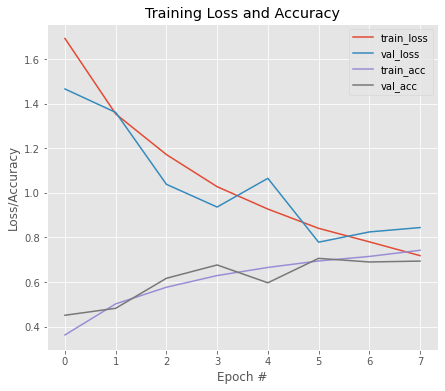


Model Performance Summary:

Min validation loss: 0.778380811214447  at EPOCH: 6

Validation Accuracy:  0.7058333158493042


In [16]:
call_model(MODEL.model_1,get_basic_callback())

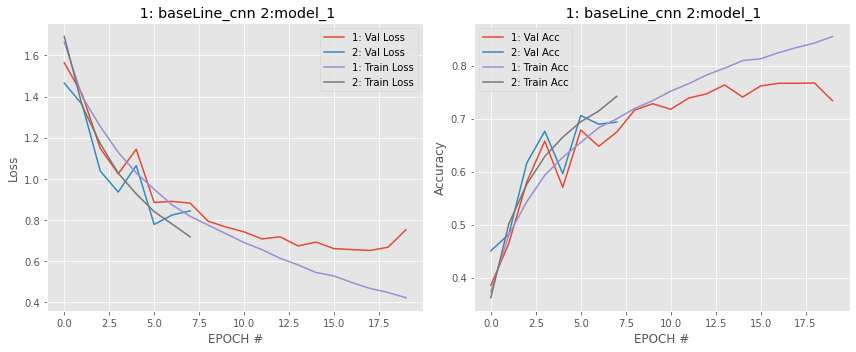

In [17]:
compare_model_performance_with_another("baseLine_cnn","model_1")

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 64, 64, 64)        1792      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 256)       295168    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 16384)             0   

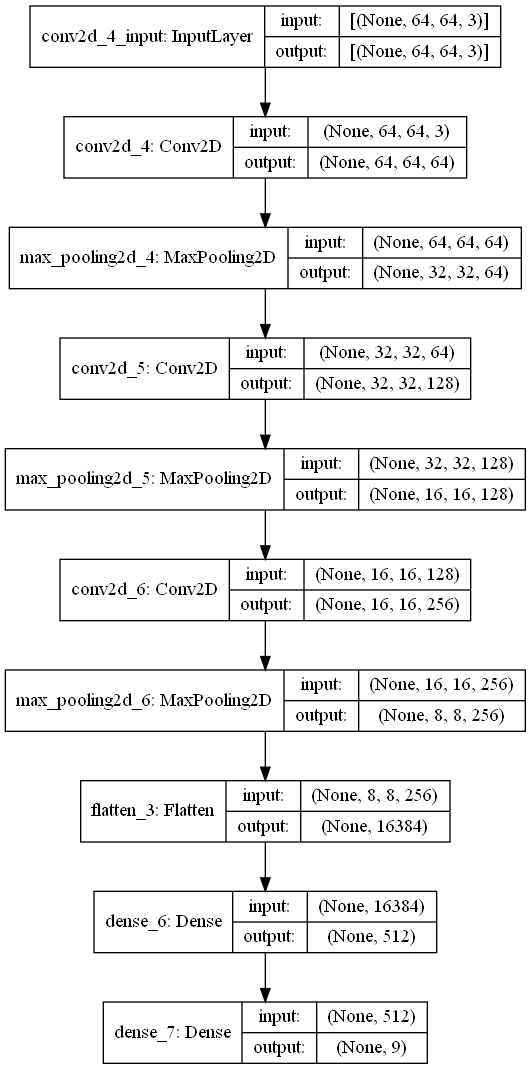

Epoch 1/70
600/600 [==============================] - 11s 17ms/step - loss: 1.9660 - accuracy: 0.2570 - val_loss: 1.5051 - val_accuracy: 0.4329
Epoch 2/70
600/600 [==============================] - 10s 17ms/step - loss: 1.4491 - accuracy: 0.4625 - val_loss: 1.4335 - val_accuracy: 0.4527
Epoch 3/70
600/600 [==============================] - 10s 17ms/step - loss: 1.2829 - accuracy: 0.5342 - val_loss: 1.0958 - val_accuracy: 0.5871
Epoch 4/70
600/600 [==============================] - 10s 17ms/step - loss: 1.0981 - accuracy: 0.6013 - val_loss: 0.9763 - val_accuracy: 0.6579
Epoch 5/70
600/600 [==============================] - 10s 17ms/step - loss: 1.0045 - accuracy: 0.6318 - val_loss: 1.0987 - val_accuracy: 0.5888s: 1.0 - ETA: 4s - loss: 1.0280 - accuracy - E
Epoch 6/70
600/600 [==============================] - 10s 17ms/step - loss: 0.8830 - accuracy: 0.6806 - val_loss: 0.7745 - val_accuracy: 0.7123 0.8 - ETA
Epoch 7/70
600/600 [==============================] - 10s 17ms/step - loss: 0.80

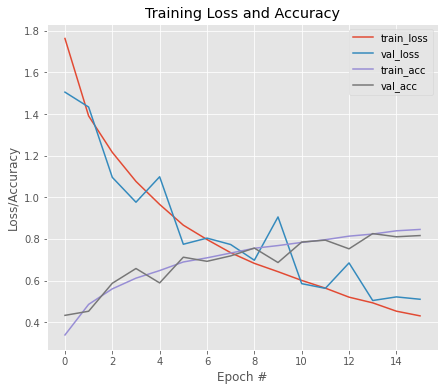


Model Performance Summary:

Min validation loss: 0.5041998028755188  at EPOCH: 14

Validation Accuracy:  0.8256250023841858


In [18]:
call_model(MODEL.model_2,get_basic_callback())

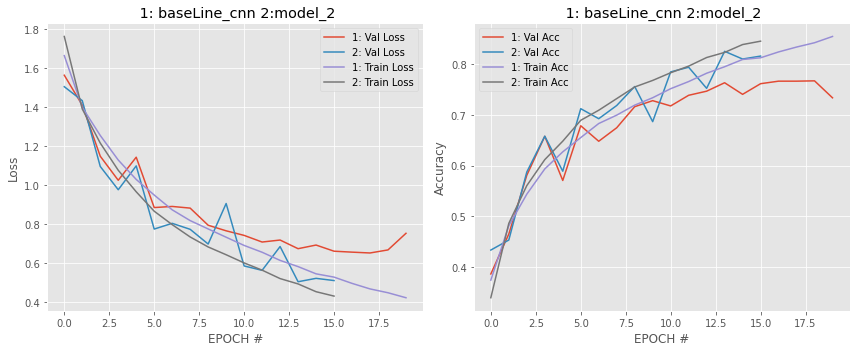

In [22]:
compare_model_performance_with_another("baseLine_cnn","model_2")

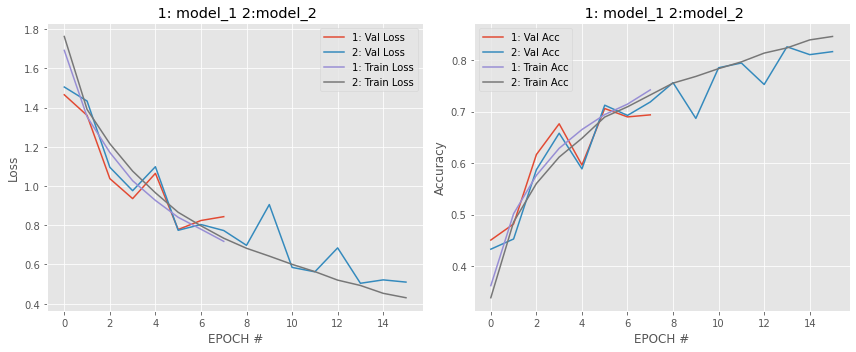

In [23]:
compare_model_performance_with_another("model_1","model_2")

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 64, 64, 64)        1792      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 256)       295168    
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 16384)             0   

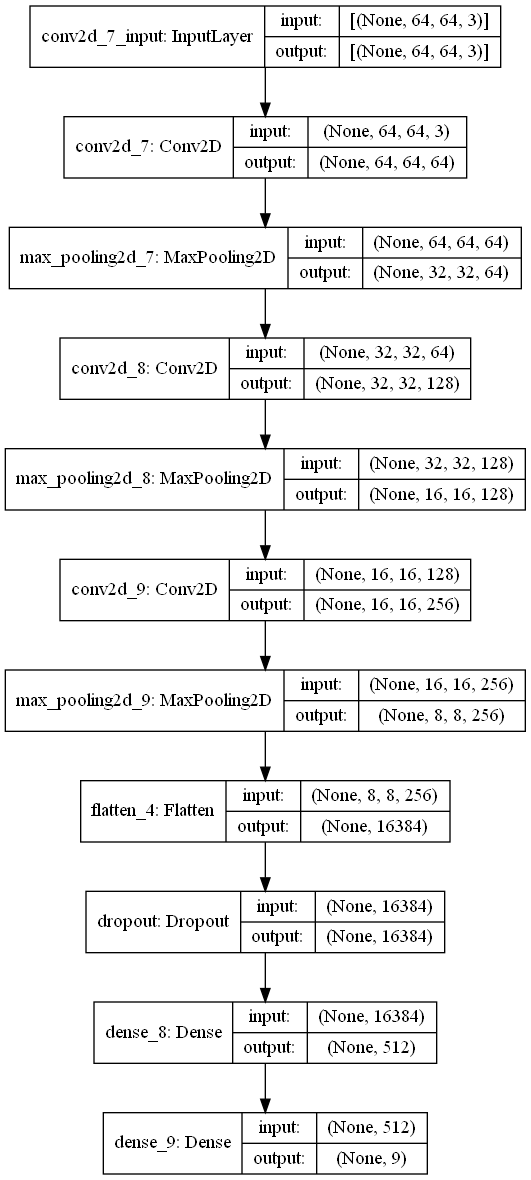

Epoch 1/70
600/600 [==============================] - 11s 17ms/step - loss: 1.9780 - accuracy: 0.2503 - val_loss: 1.5081 - val_accuracy: 0.4329 - loss: 1.9866 - ac
Epoch 2/70
600/600 [==============================] - 10s 17ms/step - loss: 1.4529 - accuracy: 0.4606 - val_loss: 1.4136 - val_accuracy: 0.4654
Epoch 3/70
600/600 [==============================] - 10s 17ms/step - loss: 1.2829 - accuracy: 0.5323 - val_loss: 1.0936 - val_accuracy: 0.5890
Epoch 4/70
600/600 [==============================] - 10s 17ms/step - loss: 1.1009 - accuracy: 0.6030 - val_loss: 0.9762 - val_accuracy: 0.6577
Epoch 5/70
600/600 [==============================] - 10s 17ms/step - loss: 1.0056 - accuracy: 0.6359 - val_loss: 1.0046 - val_accuracy: 0.6217
Epoch 6/70
600/600 [==============================] - 10s 17ms/step - loss: 0.8871 - accuracy: 0.6749 - val_loss: 0.7585 - val_accuracy: 0.7171
Epoch 7/70
600/600 [==============================] - 10s 17ms/step - loss: 0.8150 - accuracy: 0.7041 - val_loss: 0.

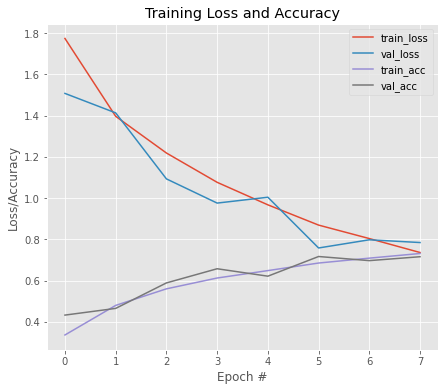


Model Performance Summary:

Min validation loss: 0.7584618926048279  at EPOCH: 6

Validation Accuracy:  0.7170833349227905


In [24]:
call_model(MODEL.model_3,get_basic_callback())

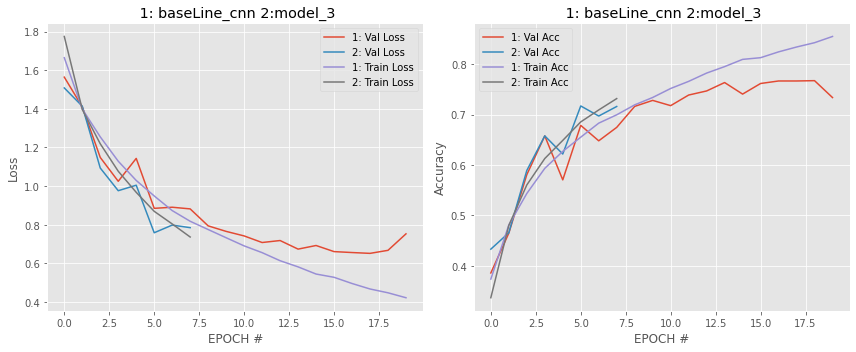

In [27]:
compare_model_performance_with_another("baseLine_cnn","model_3")

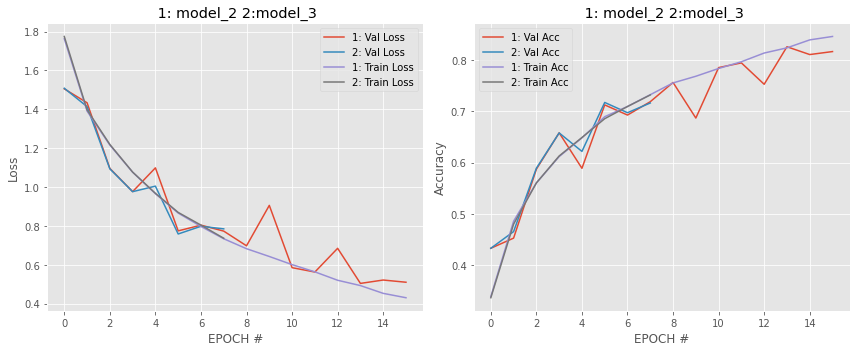

In [28]:
compare_model_performance_with_another("model_2","model_3")

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 8192)              0   

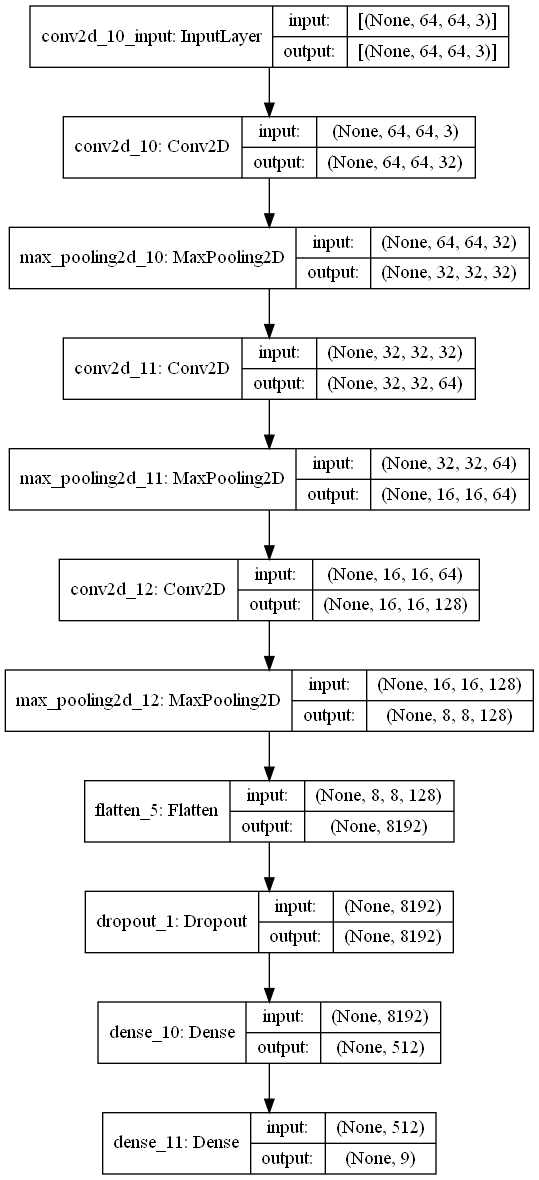

Epoch 1/70
600/600 [==============================] - 6s 9ms/step - loss: 2.0006 - accuracy: 0.2448 - val_loss: 1.4936 - val_accuracy: 0.4296
Epoch 2/70
600/600 [==============================] - 5s 9ms/step - loss: 1.4532 - accuracy: 0.4593 - val_loss: 1.5203 - val_accuracy: 0.4156
Epoch 3/70
600/600 [==============================] - 5s 9ms/step - loss: 1.2924 - accuracy: 0.5264 - val_loss: 1.0826 - val_accuracy: 0.6006
Epoch 4/70
600/600 [==============================] - 5s 9ms/step - loss: 1.1062 - accuracy: 0.5973 - val_loss: 0.9592 - val_accuracy: 0.6637
Epoch 5/70
600/600 [==============================] - 6s 9ms/step - loss: 1.0136 - accuracy: 0.6258 - val_loss: 1.1842 - val_accuracy: 0.5550
Epoch 6/70
600/600 [==============================] - 6s 9ms/step - loss: 0.8965 - accuracy: 0.6718 - val_loss: 0.7661 - val_accuracy: 0.7119
Epoch 7/70
600/600 [==============================] - 5s 9ms/step - loss: 0.8279 - accuracy: 0.6961 - val_loss: 0.7948 - val_accuracy: 0.6992
Epoch 

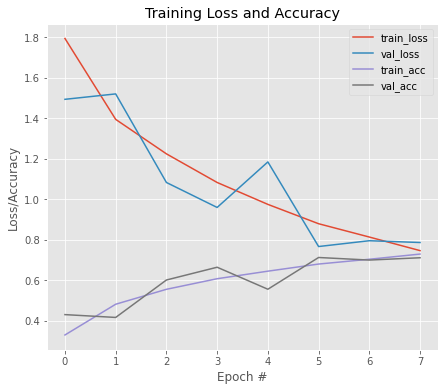


Model Performance Summary:

Min validation loss: 0.7660513520240784  at EPOCH: 6

Validation Accuracy:  0.7118750214576721


In [29]:
call_model(MODEL.model_4,get_basic_callback())

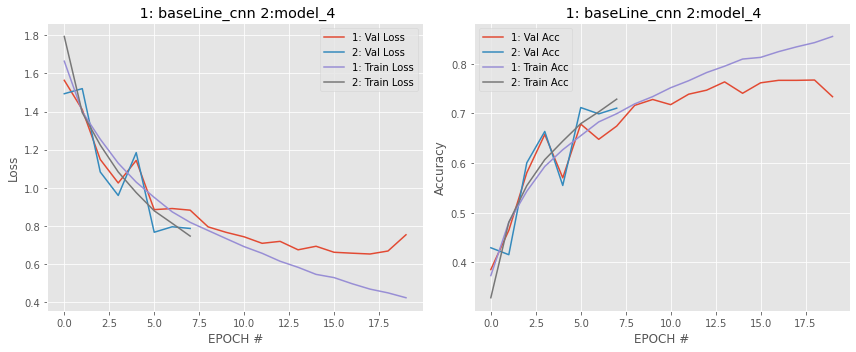

In [31]:
compare_model_performance_with_another("baseLine_cnn","model_4")

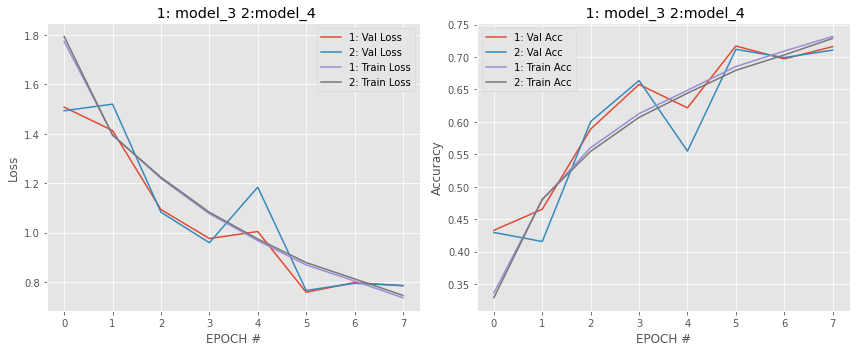

In [32]:
compare_model_performance_with_another("model_3","model_4")

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 64, 64, 64)        1792      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
spatial_dropout2d_1 (Spatial (None, 16, 16, 128)       0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 32768)             0   

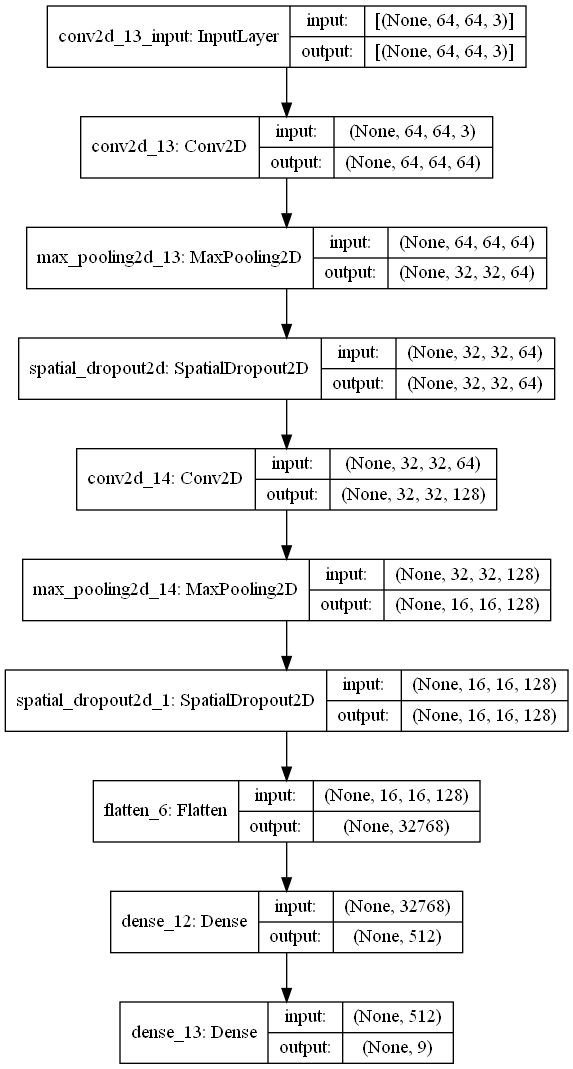

Epoch 1/70
600/600 [==============================] - 10s 16ms/step - loss: 1.9454 - accuracy: 0.2573 - val_loss: 1.4389 - val_accuracy: 0.4744
Epoch 2/70
600/600 [==============================] - 9s 15ms/step - loss: 1.4690 - accuracy: 0.4495 - val_loss: 1.6073 - val_accuracy: 0.3908
Epoch 3/70
600/600 [==============================] - 9s 15ms/step - loss: 1.3272 - accuracy: 0.5124 - val_loss: 1.1343 - val_accuracy: 0.6150
Epoch 4/70
600/600 [==============================] - 9s 15ms/step - loss: 1.1538 - accuracy: 0.5830 - val_loss: 0.9582 - val_accuracy: 0.6673
Epoch 5/70
600/600 [==============================] - 9s 15ms/step - loss: 1.0700 - accuracy: 0.6084 - val_loss: 1.0727 - val_accuracy: 0.6050
Epoch 6/70
600/600 [==============================] - 9s 15ms/step - loss: 0.9742 - accuracy: 0.6432 - val_loss: 0.8297 - val_accuracy: 0.6877
Epoch 7/70
600/600 [==============================] - 9s 15ms/step - loss: 0.8979 - accuracy: 0.6671 - val_loss: 0.8639 - val_accuracy: 0.658

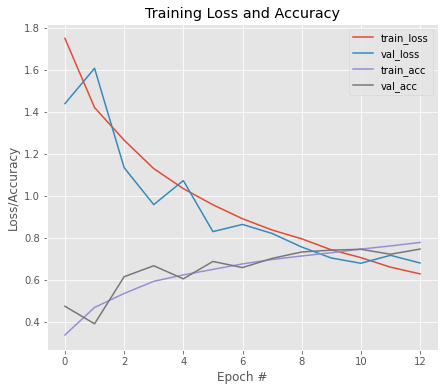


Model Performance Summary:

Min validation loss: 0.6790951490402222  at EPOCH: 11

Validation Accuracy:  0.7456250190734863


In [33]:
call_model(MODEL.model_5,get_basic_callback())

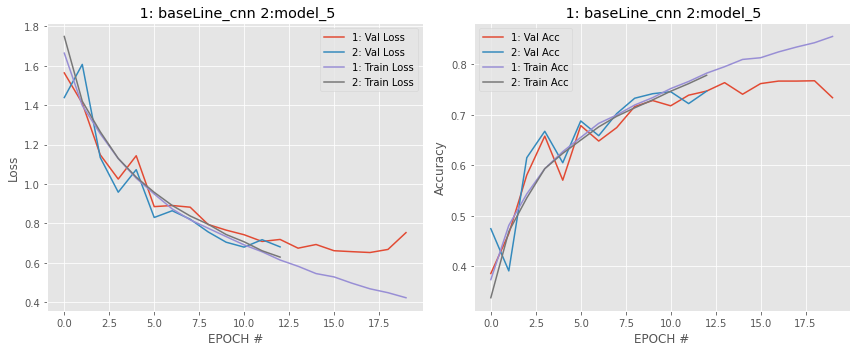

In [34]:
compare_model_performance_with_another("baseLine_cnn","model_5")

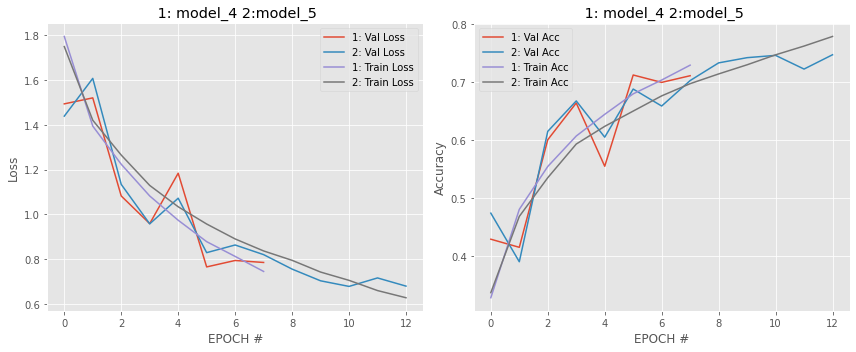

In [35]:
compare_model_performance_with_another("model_4","model_5")

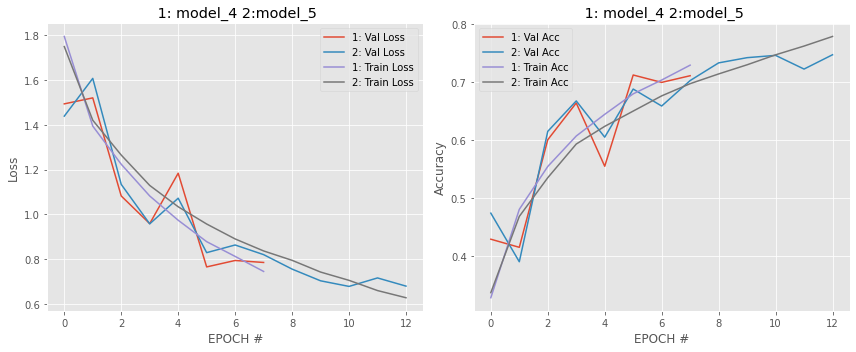

In [36]:
compare_model_performance_with_another("model_4","model_5")

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_14 (Dense)             (None, 512)               16777728  
_________________________________________________________________
dense_15 (Dense)             (None, 9)                 4617      
Total params: 16,783,241
Trainable params: 16,783,241
Non-trainable params: 0
_________________________________________________________________
None


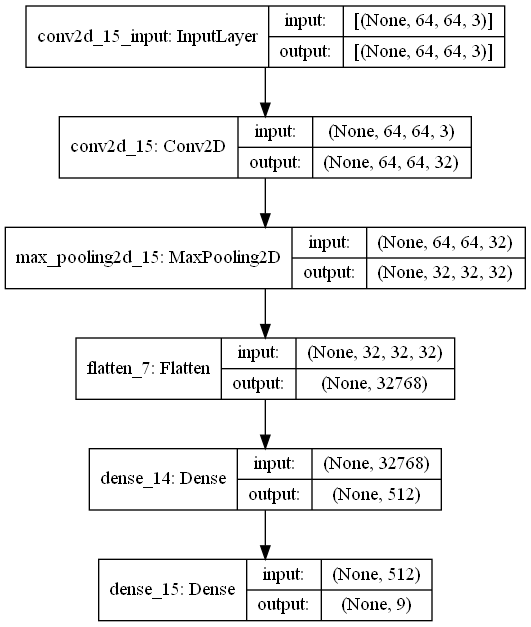

Epoch 1/70
600/600 [==============================] - 5s 9ms/step - loss: 1.8401 - accuracy: 0.3094 - val_loss: 1.5153 - val_accuracy: 0.4263
Epoch 2/70
600/600 [==============================] - 5s 8ms/step - loss: 1.4327 - accuracy: 0.4697 - val_loss: 1.3920 - val_accuracy: 0.4760
Epoch 3/70
600/600 [==============================] - 5s 8ms/step - loss: 1.3031 - accuracy: 0.5235 - val_loss: 1.1333 - val_accuracy: 0.5831
Epoch 4/70
600/600 [==============================] - 5s 8ms/step - loss: 1.1384 - accuracy: 0.5877 - val_loss: 1.0259 - val_accuracy: 0.6531
Epoch 5/70
600/600 [==============================] - 5s 8ms/step - loss: 1.0643 - accuracy: 0.6148 - val_loss: 1.0931 - val_accuracy: 0.5971
Epoch 6/70
600/600 [==============================] - 5s 8ms/step - loss: 0.9609 - accuracy: 0.6500 - val_loss: 0.8804 - val_accuracy: 0.6790
Epoch 7/70
600/600 [==============================] - 5s 8ms/step - loss: 0.8805 - accuracy: 0.6781 - val_loss: 0.9237 - val_accuracy: 0.6290
Epoch 

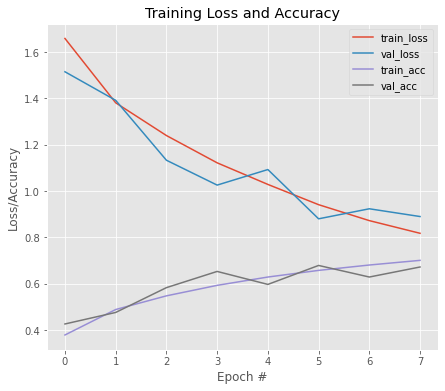


Model Performance Summary:

Min validation loss: 0.880350649356842  at EPOCH: 6

Validation Accuracy:  0.6789583563804626


In [37]:
call_model(MODEL.model_6,get_basic_callback())

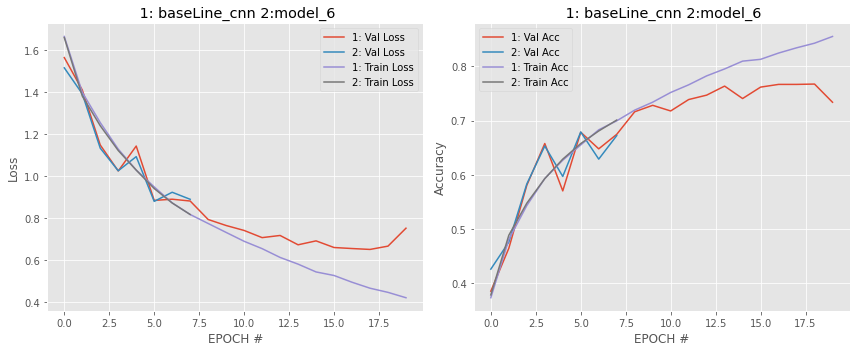

In [39]:
compare_model_performance_with_another("baseLine_cnn","model_6")

# Model Performance Summary

baseLine_cnn : 0.7672916650772095
model_1 : 0.7058333158493042
model_2 : 0.8256250023841858
model_3 : 0.7170833349227905
model_4 : 0.7118750214576721
model_5 : 0.746666669845581
model_6 : 0.6789583563804626


,Model,Val Acc
0,baseLine_cnn,0.767292
1,model_1,0.705833
2,model_2,0.825625
3,model_3,0.717083
4,model_4,0.711875
5,model_5,0.746667
6,model_6,0.678958


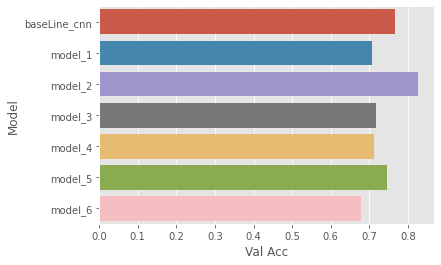

In [40]:
model_perfromance_summary()

# Image Data Augmentation
 ### 1. Augmentation Range
 ### 2. Horizontal & Vertical Flip

#### MODEL.MODEL_4

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 8192)              0   

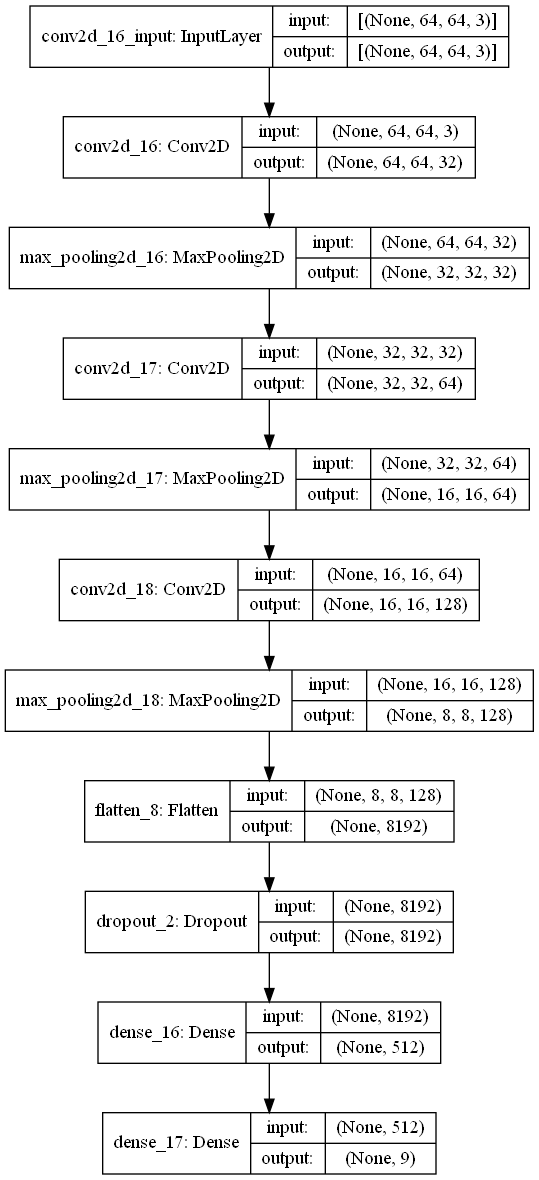

Epoch 1/70
600/600 [==============================] - 18s 30ms/step - loss: 2.0199 - accuracy: 0.2346 - val_loss: 1.7927 - val_accuracy: 0.3319
Epoch 2/70
600/600 [==============================] - 17s 29ms/step - loss: 1.5272 - accuracy: 0.4208 - val_loss: 1.3285 - val_accuracy: 0.5063
Epoch 3/70
600/600 [==============================] - 18s 30ms/step - loss: 1.3487 - accuracy: 0.5029 - val_loss: 1.2369 - val_accuracy: 0.5571
Epoch 4/70
600/600 [==============================] - 18s 30ms/step - loss: 1.1958 - accuracy: 0.5617 - val_loss: 0.9994 - val_accuracy: 0.6408
Epoch 5/70
600/600 [==============================] - 18s 30ms/step - loss: 1.0948 - accuracy: 0.5965 - val_loss: 0.8746 - val_accuracy: 0.6919
Epoch 6/70
600/600 [==============================] - 18s 30ms/step - loss: 1.0185 - accuracy: 0.6287 - val_loss: 1.1120 - val_accuracy: 0.5885
Epoch 7/70
600/600 [==============================] - 18s 30ms/step - loss: 0.9428 - accuracy: 0.6630 - val_loss: 0.9293 - val_accuracy:

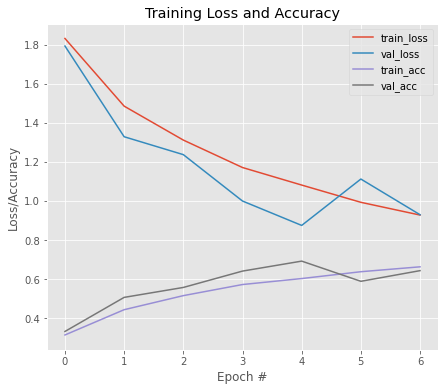


Model Performance Summary:

Min validation loss: 0.8746169805526733  at EPOCH: 5

Validation Accuracy:  0.6918749809265137


In [41]:
 data_generator_full = tf.keras.preprocessing.image.ImageDataGenerator(
                          shear_range=0.2,
                          zoom_range=0.2,
                          rotation_range=30,    
                          width_shift_range=0.2,
                          height_shift_range=0.2,
                          horizontal_flip=True,
                          vertical_flip=True
                        )
train_generator_full = data_generator_full.flow(g_trainX, \
                                                  g_trainY, batch_size=32)                        
call_model_with_augmentation(MODEL.model_4,get_basic_callback(),\
                             generator_obj = train_generator_full)

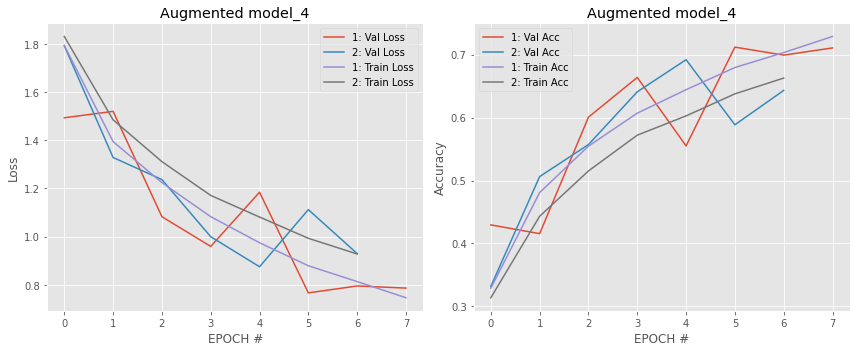

In [43]:
compare_model_performance_with_augmentation("model_4")

In [44]:
for item in g_record_v3.store:
    print(item)

model_4


#### Horizontal and Vertical Flip

In [45]:
 data_generator_flip = tf.keras.preprocessing.image.ImageDataGenerator(      
                          horizontal_flip=True,
                          vertical_flip=True
                        )
 train_generator_flip = data_generator_flip.flow(g_trainX, g_trainY, \
                                                 batch_size=32)                        


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 8192)              0   

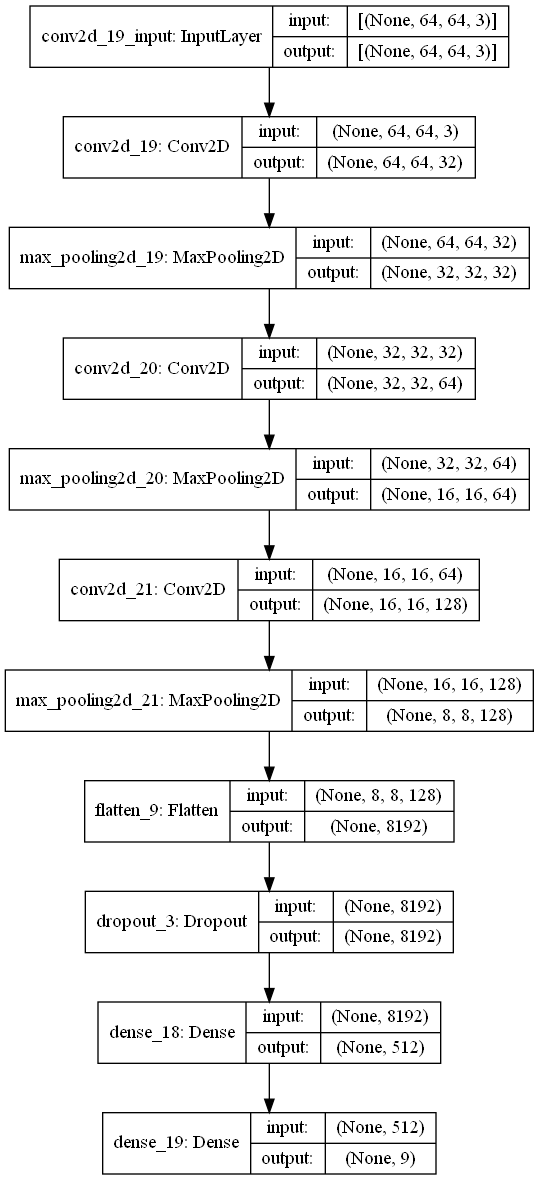

Epoch 1/70
600/600 [==============================] - 6s 10ms/step - loss: 2.0010 - accuracy: 0.2463 - val_loss: 1.4016 - val_accuracy: 0.5019
Epoch 2/70
600/600 [==============================] - 5s 9ms/step - loss: 1.4574 - accuracy: 0.4532 - val_loss: 1.2143 - val_accuracy: 0.5419
Epoch 3/70
600/600 [==============================] - 5s 9ms/step - loss: 1.2698 - accuracy: 0.5307 - val_loss: 1.1053 - val_accuracy: 0.6035
Epoch 4/70
600/600 [==============================] - 5s 9ms/step - loss: 1.1305 - accuracy: 0.5879 - val_loss: 0.9302 - val_accuracy: 0.6619
Epoch 5/70
600/600 [==============================] - 5s 9ms/step - loss: 1.0181 - accuracy: 0.6278 - val_loss: 1.0516 - val_accuracy: 0.5981
Epoch 6/70
600/600 [==============================] - 5s 9ms/step - loss: 0.9198 - accuracy: 0.6671 - val_loss: 0.8469 - val_accuracy: 0.6829
Epoch 7/70
600/600 [==============================] - 5s 9ms/step - loss: 0.8596 - accuracy: 0.6851 - val_loss: 0.8113 - val_accuracy: 0.6940
Epoch

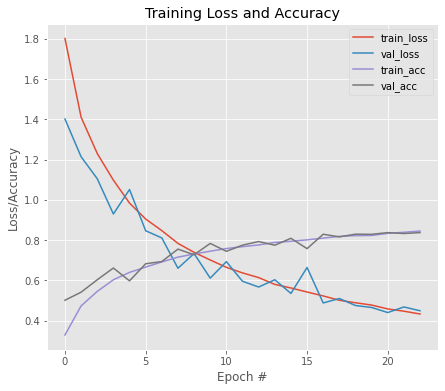


Model Performance Summary:

Min validation loss: 0.44077128171920776  at EPOCH: 21

Validation Accuracy:  0.8377083539962769


In [46]:
 call_model_with_augmentation(MODEL.model_4,get_basic_callback(),\
                             generator_obj = train_generator_flip)

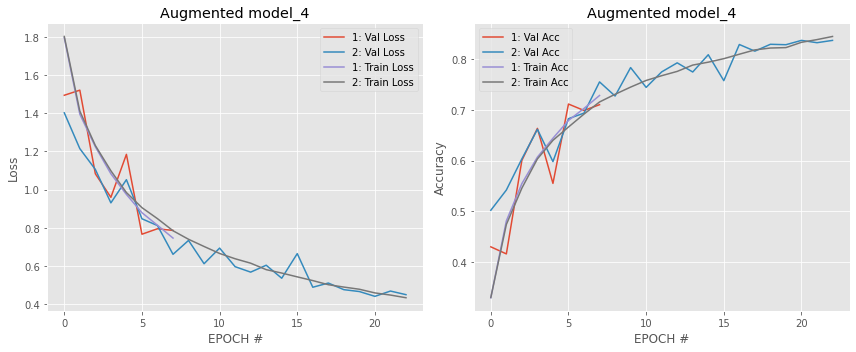

In [51]:
compare_model_performance_with_augmentation("model_4")

## MODEL.MODEL_3

In [57]:
 data_generator_full = tf.keras.preprocessing.image.ImageDataGenerator(
                          shear_range=0.2,
                          zoom_range=0.2,
                          rotation_range=30,    
                          width_shift_range=0.2,
                          height_shift_range=0.2,
                          horizontal_flip=True,
                          vertical_flip=True
                        )
train_generator_full = data_generator_full.flow(g_trainX, \
                                                  g_trainY, batch_size=32)                        


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 64, 64, 64)        1792      
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 16, 16, 256)       295168    
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 8, 8, 256)         0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 16384)             0   

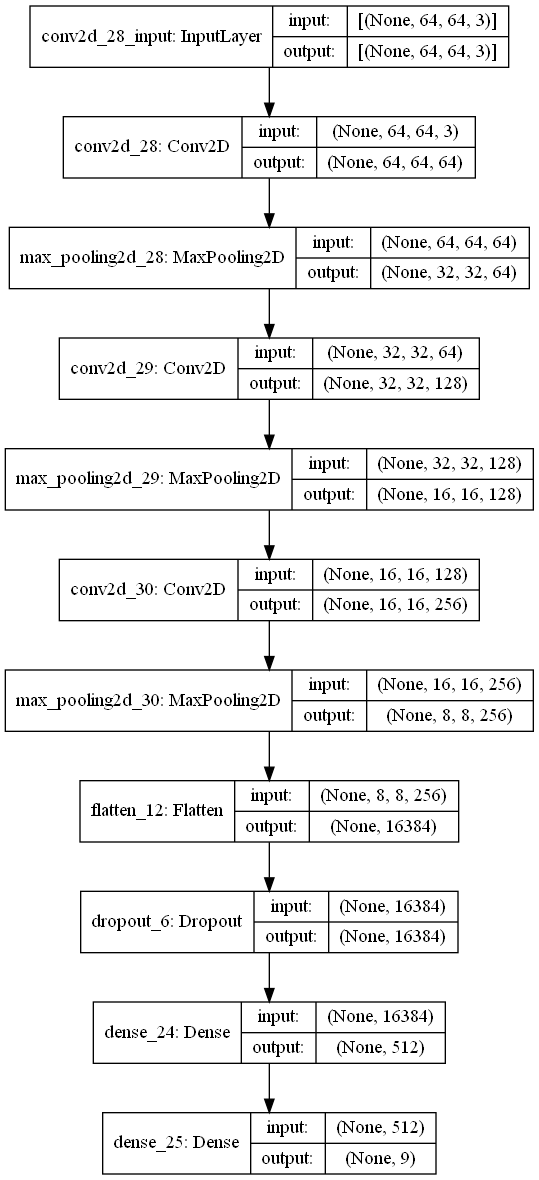

Epoch 1/70
600/600 [==============================] - 19s 31ms/step - loss: 2.0013 - accuracy: 0.2200 - val_loss: 1.5036 - val_accuracy: 0.4165
Epoch 2/70
600/600 [==============================] - 18s 30ms/step - loss: 1.5094 - accuracy: 0.4359 - val_loss: 1.2699 - val_accuracy: 0.5548
Epoch 3/70
600/600 [==============================] - 18s 29ms/step - loss: 1.3434 - accuracy: 0.5056 - val_loss: 1.1159 - val_accuracy: 0.5929
Epoch 4/70
600/600 [==============================] - 18s 30ms/step - loss: 1.2020 - accuracy: 0.5686 - val_loss: 0.9907 - val_accuracy: 0.6660
Epoch 5/70
600/600 [==============================] - 18s 30ms/step - loss: 1.0906 - accuracy: 0.6028 - val_loss: 0.9470 - val_accuracy: 0.6635
Epoch 6/70
600/600 [==============================] - 19s 31ms/step - loss: 1.0053 - accuracy: 0.6291 - val_loss: 0.8256 - val_accuracy: 0.7073
Epoch 7/70
600/600 [==============================] - 19s 31ms/step - loss: 0.9247 - accuracy: 0.6662 - val_loss: 0.7417 - val_accuracy:

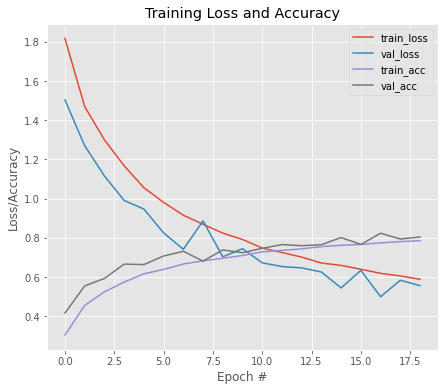


Model Performance Summary:

Min validation loss: 0.49993768334388733  at EPOCH: 17

Validation Accuracy:  0.8237500190734863


In [58]:
call_model_with_augmentation(MODEL.model_3,get_basic_callback(),\
                             generator_obj = train_generator_full)

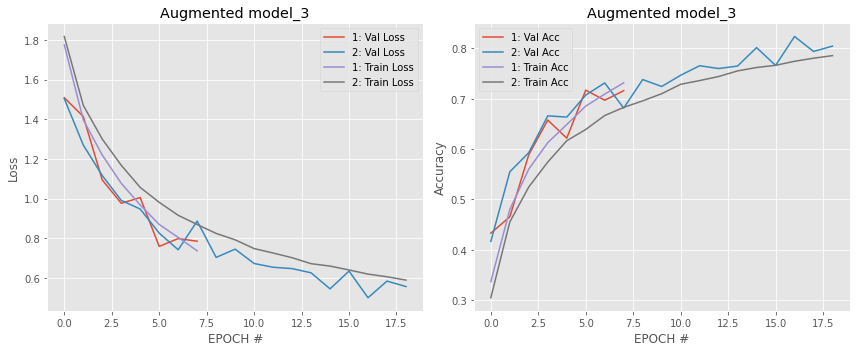

In [59]:
compare_model_performance_with_augmentation("model_3")

## Horizontal and Vertical Flip

In [60]:
 data_generator_flip = tf.keras.preprocessing.image.ImageDataGenerator(      
                          horizontal_flip=True,
                          vertical_flip=True
                        )
 train_generator_flip = data_generator_flip.flow(g_trainX, \
                                                  g_trainY, batch_size=32)                        


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 64, 64, 64)        1792      
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 16, 16, 256)       295168    
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 8, 8, 256)         0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 16384)             0   

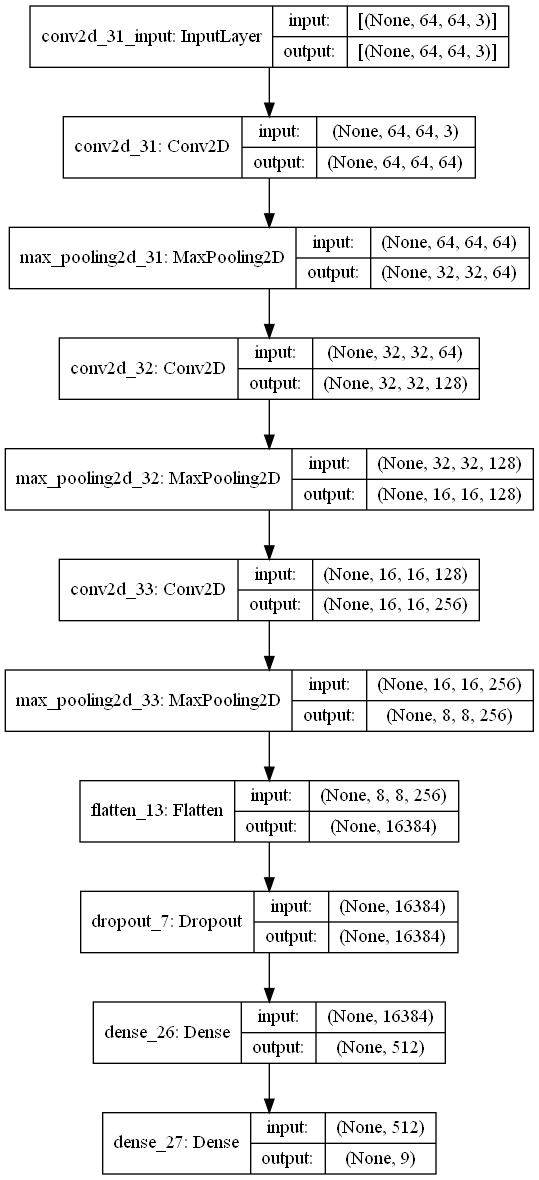

Epoch 1/70
600/600 [==============================] - 11s 18ms/step - loss: 1.9804 - accuracy: 0.2364 - val_loss: 1.4729 - val_accuracy: 0.4256
Epoch 2/70
600/600 [==============================] - 10s 17ms/step - loss: 1.4473 - accuracy: 0.4610 - val_loss: 1.2768 - val_accuracy: 0.5446
Epoch 3/70
600/600 [==============================] - 10s 17ms/step - loss: 1.2466 - accuracy: 0.5439 - val_loss: 1.0973 - val_accuracy: 0.6027
Epoch 4/70
600/600 [==============================] - 10s 17ms/step - loss: 1.1286 - accuracy: 0.5977 - val_loss: 1.0562 - val_accuracy: 0.6044
Epoch 5/70
600/600 [==============================] - 10s 17ms/step - loss: 1.0086 - accuracy: 0.6314 - val_loss: 0.8958 - val_accuracy: 0.6767
Epoch 6/70
600/600 [==============================] - 10s 17ms/step - loss: 0.9240 - accuracy: 0.6567 - val_loss: 0.9507 - val_accuracy: 0.6394
Epoch 7/70
600/600 [==============================] - 11s 18ms/step - loss: 0.8502 - accuracy: 0.6893 - val_loss: 0.8201 - val_accuracy:

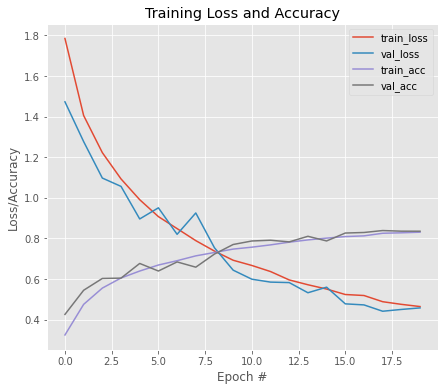


Model Performance Summary:

Min validation loss: 0.44125819206237793  at EPOCH: 18

Validation Accuracy:  0.8387500047683716


In [61]:
 call_model_with_augmentation(MODEL.model_3,get_basic_callback(),\
                             generator_obj = train_generator_flip)

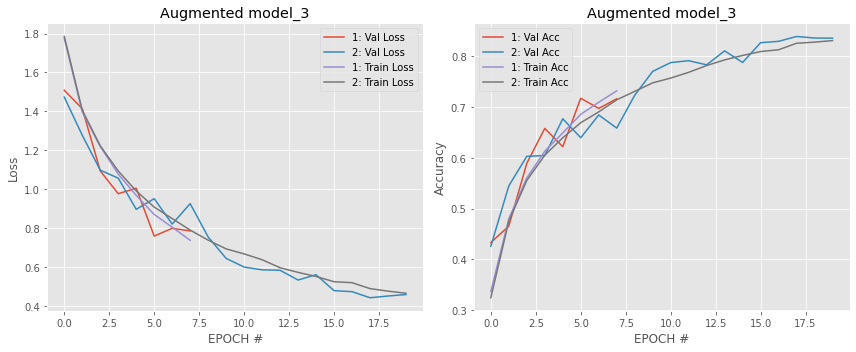

In [63]:
compare_model_performance_with_augmentation("model_3")

# MODEL.MODEL_5

In [64]:
 data_generator_full = tf.keras.preprocessing.image.ImageDataGenerator(
                          shear_range=0.2,
                          zoom_range=0.2,
                          rotation_range=30,    
                          width_shift_range=0.2,
                          height_shift_range=0.2,
                          horizontal_flip=True,
                          vertical_flip=True
                        )
train_generator_full = data_generator_full.flow(g_trainX, \
                                                  g_trainY, batch_size=32) 

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 64, 64, 64)        1792      
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
spatial_dropout2d_2 (Spatial (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
spatial_dropout2d_3 (Spatial (None, 16, 16, 128)       0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 32768)             0   

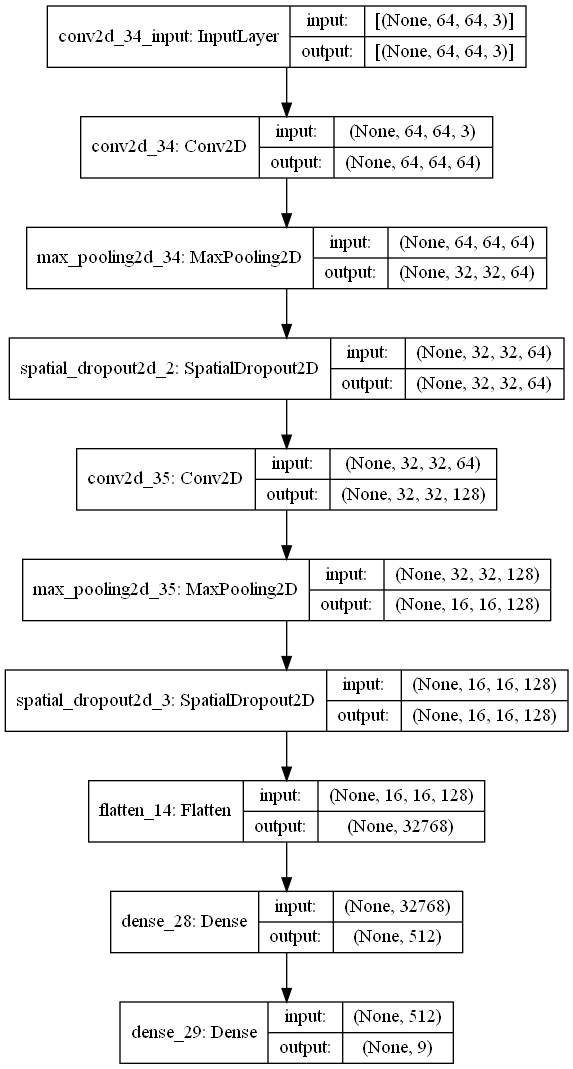

Epoch 1/70
600/600 [==============================] - 18s 30ms/step - loss: 1.9561 - accuracy: 0.2495 - val_loss: 1.4677 - val_accuracy: 0.4933
Epoch 2/70
600/600 [==============================] - 18s 30ms/step - loss: 1.5402 - accuracy: 0.4252 - val_loss: 1.4531 - val_accuracy: 0.4869
Epoch 3/70
600/600 [==============================] - 18s 30ms/step - loss: 1.3875 - accuracy: 0.4887 - val_loss: 1.1386 - val_accuracy: 0.5865
Epoch 4/70
600/600 [==============================] - 18s 30ms/step - loss: 1.2560 - accuracy: 0.5401 - val_loss: 1.0854 - val_accuracy: 0.6031
Epoch 5/70
600/600 [==============================] - 18s 30ms/step - loss: 1.1781 - accuracy: 0.5660 - val_loss: 0.9687 - val_accuracy: 0.6598
Epoch 6/70
600/600 [==============================] - 18s 30ms/step - loss: 1.1150 - accuracy: 0.5950 - val_loss: 0.9349 - val_accuracy: 0.6690
Epoch 7/70
600/600 [==============================] - 18s 30ms/step - loss: 1.0307 - accuracy: 0.6199 - val_loss: 0.8822 - val_accuracy:

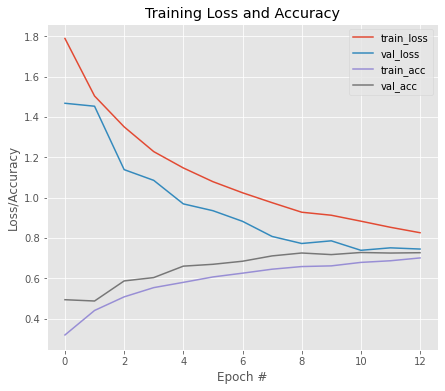


Model Performance Summary:

Min validation loss: 0.7383966445922852  at EPOCH: 11

Validation Accuracy:  0.7275000214576721


In [65]:
call_model_with_augmentation(MODEL.model_5,get_basic_callback(),\
                             generator_obj = train_generator_full)

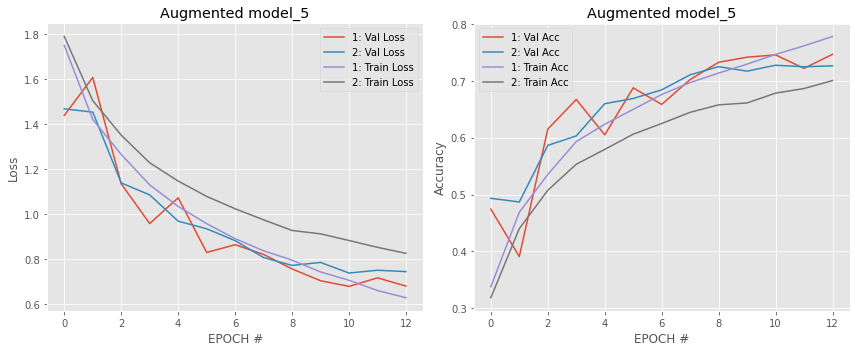

In [66]:
compare_model_performance_with_augmentation("model_5")

In [67]:
 data_generator_flip = tf.keras.preprocessing.image.ImageDataGenerator(      
                          horizontal_flip=True,
                          vertical_flip=True
                        )
 train_generator_flip = data_generator_flip.flow(g_trainX, \
                                                  g_trainY, batch_size=32)                        


Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 64, 64, 64)        1792      
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
spatial_dropout2d_4 (Spatial (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
spatial_dropout2d_5 (Spatial (None, 16, 16, 128)       0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 32768)             0   

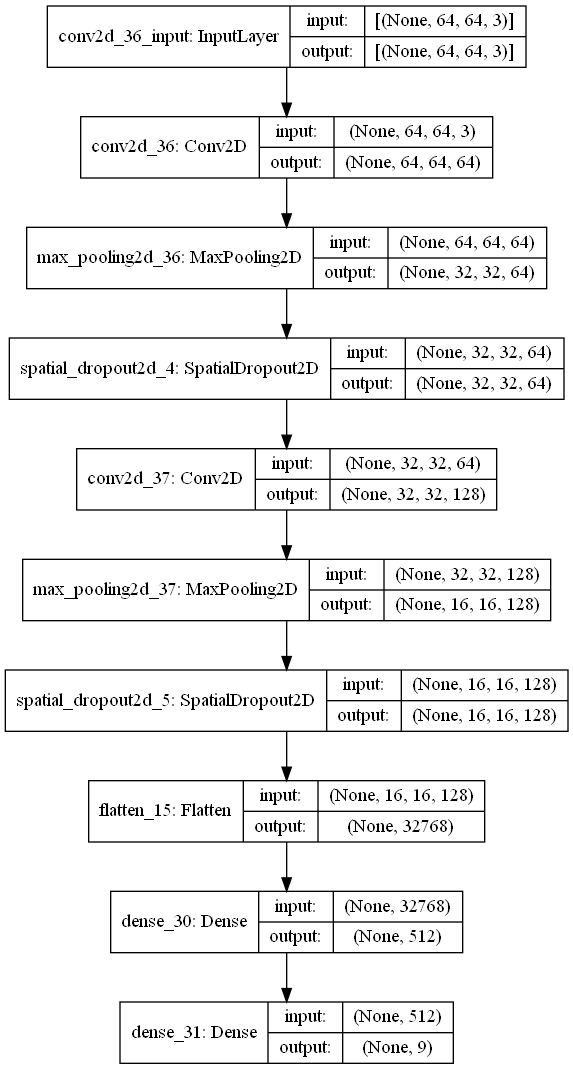

Epoch 1/70
600/600 [==============================] - 10s 17ms/step - loss: 1.9520 - accuracy: 0.2495 - val_loss: 1.4574 - val_accuracy: 0.4531
Epoch 2/70
600/600 [==============================] - 10s 16ms/step - loss: 1.4701 - accuracy: 0.4478 - val_loss: 1.3900 - val_accuracy: 0.4933
Epoch 3/70
600/600 [==============================] - 10s 16ms/step - loss: 1.3166 - accuracy: 0.5105 - val_loss: 1.0799 - val_accuracy: 0.6460
Epoch 4/70
600/600 [==============================] - 10s 16ms/step - loss: 1.1796 - accuracy: 0.5669 - val_loss: 0.9925 - val_accuracy: 0.6469
Epoch 5/70
600/600 [==============================] - 10s 16ms/step - loss: 1.0858 - accuracy: 0.6023 - val_loss: 0.9888 - val_accuracy: 0.6327
Epoch 6/70
600/600 [==============================] - 10s 16ms/step - loss: 0.9985 - accuracy: 0.6325 - val_loss: 0.9132 - val_accuracy: 0.6731
Epoch 7/70
600/600 [==============================] - 10s 16ms/step - loss: 0.9466 - accuracy: 0.6542 - val_loss: 0.8175 - val_accuracy:

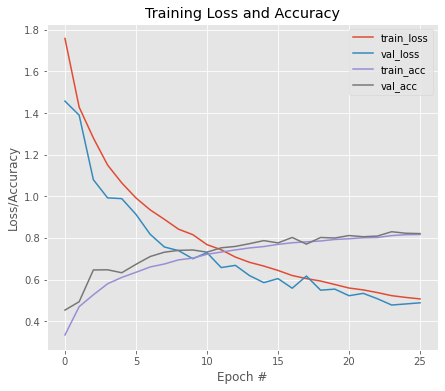


Model Performance Summary:

Min validation loss: 0.4775574207305908  at EPOCH: 24

Validation Accuracy:  0.8297916650772095


In [68]:
 call_model_with_augmentation(MODEL.model_5,get_basic_callback(),\
                             generator_obj = train_generator_flip)

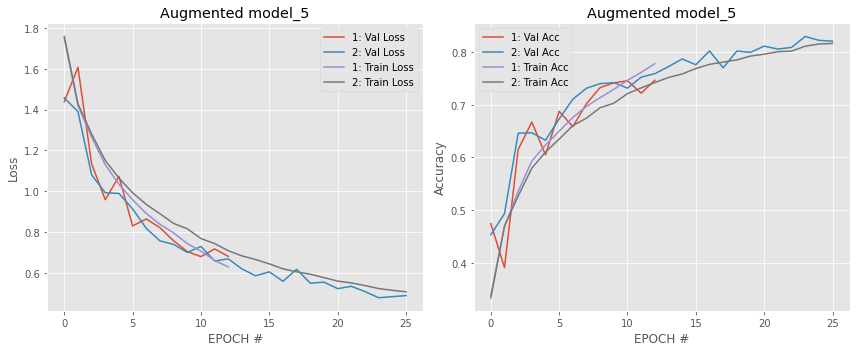

In [72]:
compare_model_performance_with_augmentation("model_5")

# Model Perfromance Summary With Augmentation

model_4 : 0.8377083539962769
model_3 : 0.8387500047683716
model_5 : 0.8297916650772095


,Model,Val Acc
0,model_4,0.837708
1,model_3,0.838750
2,model_5,0.829792


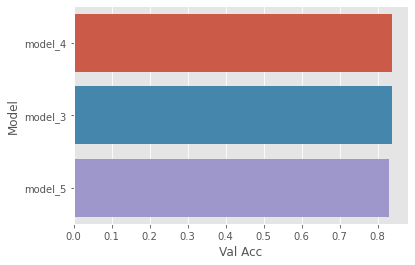

In [71]:
model_perfromance_summary_with_augmentation()

#### Model 3 and 4 has performed best amongest choosen model with horizontal & vertical flip

# Varying Learning Rate:

Model: "baseLine_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_38 (Conv2D)           (None, 64, 64, 64)        1792      
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 65536)             0         
_________________________________________________________________
dense_32 (Dense)             (None, 512)               33554944  
_________________________________________________________________
dense_33 (Dense)             (None, 9)                 4617      
Total params: 33,561,353
Trainable params: 33,561,353
Non-trainable params: 0
_________________________________________________________________
None


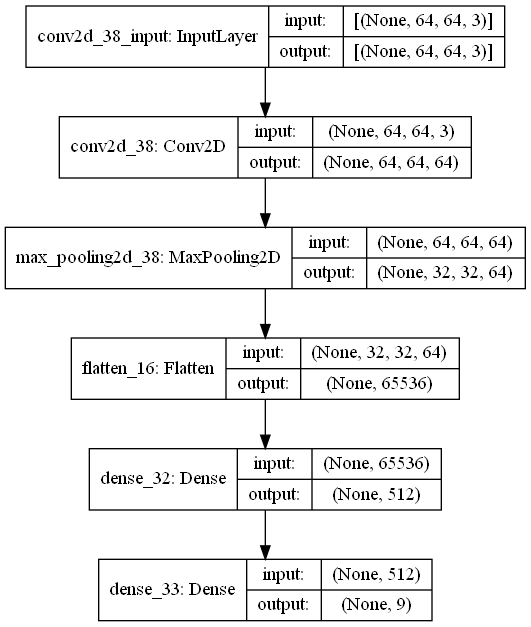

Epoch 1/70

Epoch 00001: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 9s 14ms/step - loss: 1.8390 - accuracy: 0.3087 - val_loss: 1.5549 - val_accuracy: 0.3885
Epoch 2/70

Epoch 00002: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 8s 14ms/step - loss: 1.4484 - accuracy: 0.4605 - val_loss: 1.4139 - val_accuracy: 0.4642
Epoch 3/70

Epoch 00003: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 8s 14ms/step - loss: 1.3175 - accuracy: 0.5166 - val_loss: 1.1394 - val_accuracy: 0.5869
Epoch 4/70

Epoch 00004: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 8s 14ms/step - loss: 1.1474 - accuracy: 0.5862 - val_loss: 1.0269 - val_accuracy: 0.6573
Epoch 5/70

Epoch 00005: LearningRateScheduler reducing learning rate to 0.00999999977648258

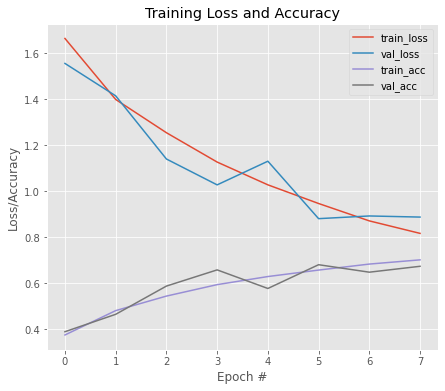


Model Performance Summary:

Min validation loss: 0.8800281882286072  at EPOCH: 6

Validation Accuracy:  0.6797916889190674


In [73]:
call_model(MODEL.baseLine_cnn,get_basic_and_lrs_callback(),model_history= \
           g_record_v2)

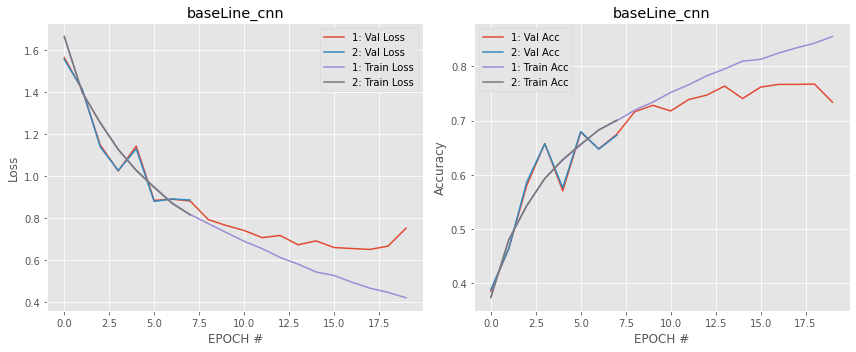

In [76]:
compare_model_performance_with_lrs("baseLine_cnn")

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 64, 64, 64)        1792      
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 32768)             0         
_________________________________________________________________
dense_34 (Dense)             (None, 512)               16777728  
_________________________________________________________________
dense_35 (Dense)             (None, 9)                 4617

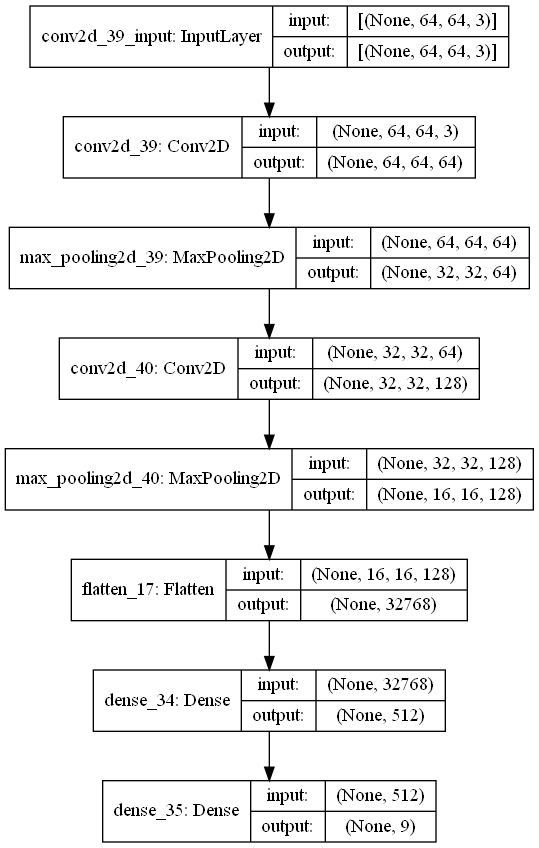

Epoch 1/70

Epoch 00001: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 9s 15ms/step - loss: 1.8929 - accuracy: 0.2838 - val_loss: 1.4651 - val_accuracy: 0.4490
Epoch 2/70

Epoch 00002: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 9s 15ms/step - loss: 1.4129 - accuracy: 0.4753 - val_loss: 1.3603 - val_accuracy: 0.4835
Epoch 3/70

Epoch 00003: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 9s 15ms/step - loss: 1.2400 - accuracy: 0.5501 - val_loss: 1.0386 - val_accuracy: 0.6146
Epoch 4/70

Epoch 00004: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 9s 15ms/step - loss: 1.0496 - accuracy: 0.6171 - val_loss: 0.9346 - val_accuracy: 0.6792
Epoch 5/70

Epoch 00005: LearningRateScheduler reducing learning rate to 0.00999999977648258

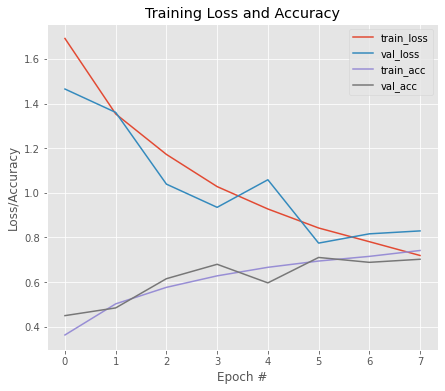


Model Performance Summary:

Min validation loss: 0.774132490158081  at EPOCH: 6

Validation Accuracy:  0.7097916603088379


In [77]:
call_model(MODEL.model_1,get_basic_and_lrs_callback(),model_history= \
           g_record_v2)

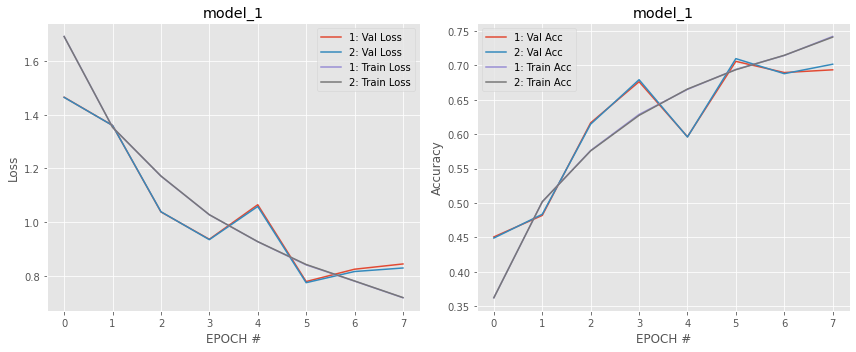

In [78]:
compare_model_performance_with_lrs("model_1")

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_41 (Conv2D)           (None, 64, 64, 64)        1792      
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 16, 16, 256)       295168    
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 8, 8, 256)         0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 16384)             0   

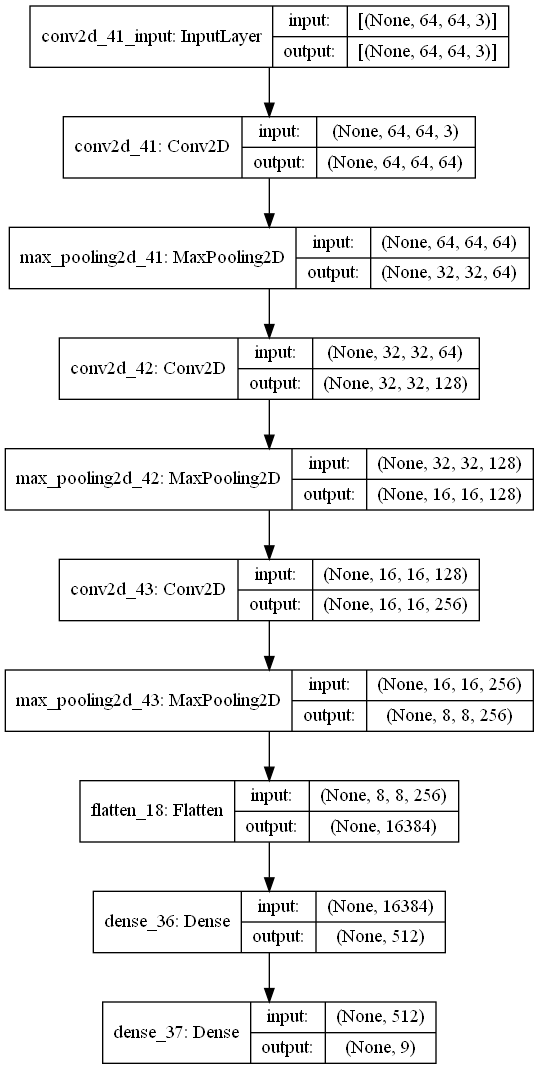

Epoch 1/70

Epoch 00001: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 11s 18ms/step - loss: 1.9662 - accuracy: 0.2573 - val_loss: 1.5006 - val_accuracy: 0.4377
Epoch 2/70

Epoch 00002: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 10s 17ms/step - loss: 1.4481 - accuracy: 0.4640 - val_loss: 1.4369 - val_accuracy: 0.4529
Epoch 3/70

Epoch 00003: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 10s 17ms/step - loss: 1.2806 - accuracy: 0.5352 - val_loss: 1.0904 - val_accuracy: 0.5896.2820 - accuracy: 
Epoch 4/70

Epoch 00004: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 10s 17ms/step - loss: 1.0958 - accuracy: 0.6028 - val_loss: 0.9772 - val_accuracy: 0.6567
Epoch 5/70

Epoch 00005: LearningRateScheduler reducing learning rate 

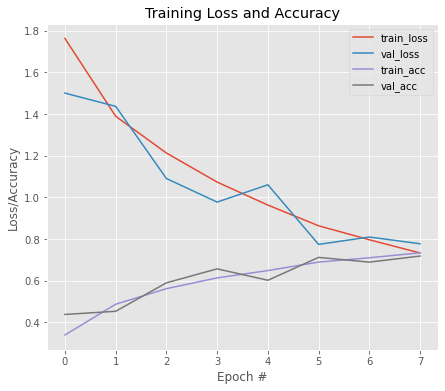


Model Performance Summary:

Min validation loss: 0.7740762829780579  at EPOCH: 6

Validation Accuracy:  0.7116666436195374


In [79]:
call_model(MODEL.model_2,get_basic_and_lrs_callback(),model_history= \
           g_record_v2)

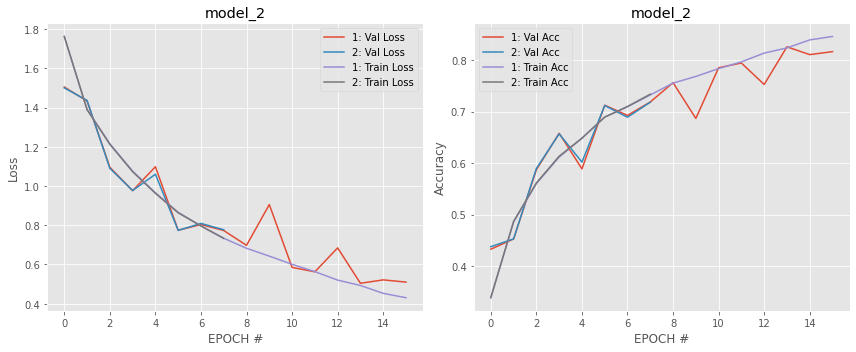

In [81]:
compare_model_performance_with_lrs("model_2")

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 64, 64, 64)        1792      
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 16, 16, 256)       295168    
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 8, 8, 256)         0         
_________________________________________________________________
flatten_19 (Flatten)         (None, 16384)             0   

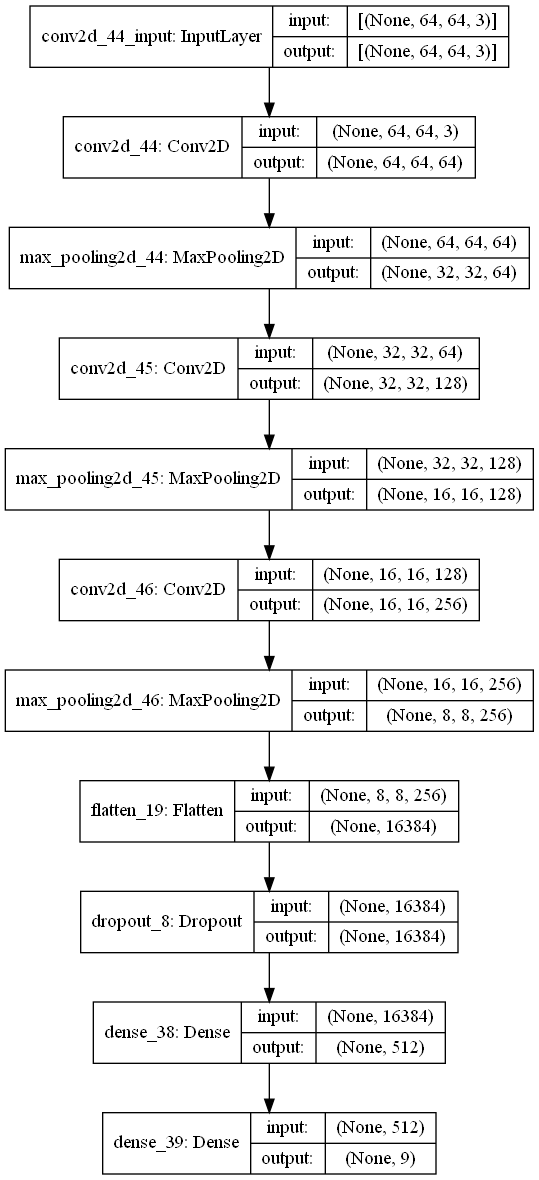

Epoch 1/70

Epoch 00001: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 11s 18ms/step - loss: 1.9778 - accuracy: 0.2496 - val_loss: 1.5077 - val_accuracy: 0.4313
Epoch 2/70

Epoch 00002: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 10s 17ms/step - loss: 1.4517 - accuracy: 0.4597 - val_loss: 1.4221 - val_accuracy: 0.4619
Epoch 3/70

Epoch 00003: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 10s 17ms/step - loss: 1.2821 - accuracy: 0.5338 - val_loss: 1.0914 - val_accuracy: 0.5879
Epoch 4/70

Epoch 00004: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 10s 17ms/step - loss: 1.0985 - accuracy: 0.6042 - val_loss: 0.9709 - val_accuracy: 0.65752 - ac -
Epoch 5/70

Epoch 00005: LearningRateScheduler reducing learning rate to 0.00999

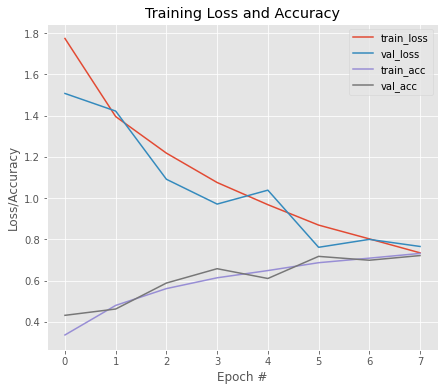


Model Performance Summary:

Min validation loss: 0.7613182067871094  at EPOCH: 6

Validation Accuracy:  0.7172916531562805


In [82]:
call_model(MODEL.model_3,get_basic_and_lrs_callback(),model_history= \
           g_record_v2)

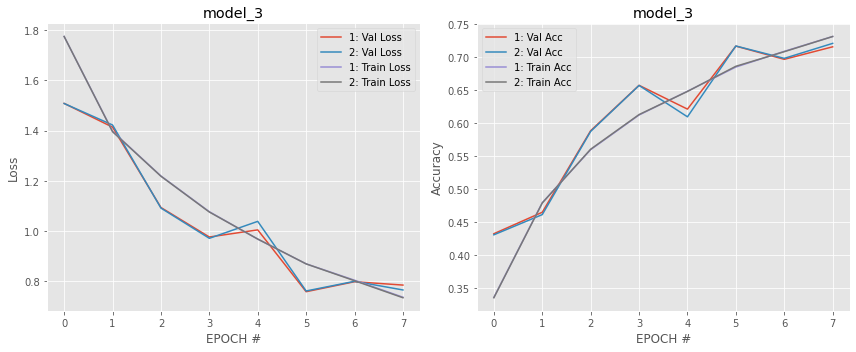

In [83]:
compare_model_performance_with_lrs("model_3")

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_47 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_20 (Flatten)         (None, 8192)              0   

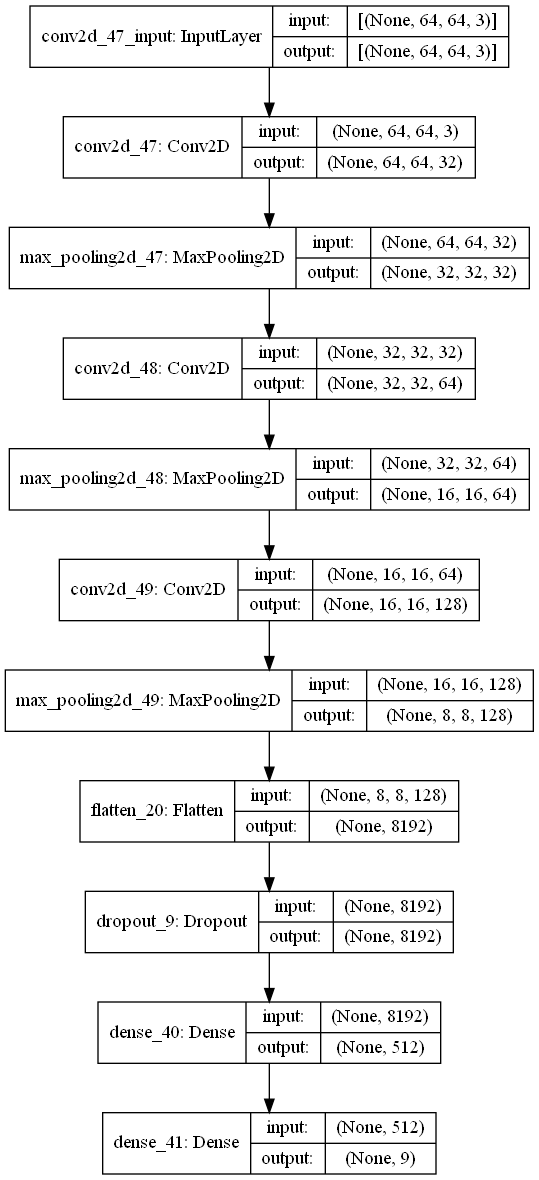

Epoch 1/70

Epoch 00001: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 6s 9ms/step - loss: 2.0011 - accuracy: 0.2450 - val_loss: 1.5063 - val_accuracy: 0.4223
Epoch 2/70

Epoch 00002: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 5s 9ms/step - loss: 1.4525 - accuracy: 0.4592 - val_loss: 1.5259 - val_accuracy: 0.4165
Epoch 3/70

Epoch 00003: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 5s 9ms/step - loss: 1.2918 - accuracy: 0.5282 - val_loss: 1.0777 - val_accuracy: 0.6017
Epoch 4/70

Epoch 00004: LearningRateScheduler reducing learning rate to 0.009999999776482582.
600/600 [==============================] - 5s 9ms/step - loss: 1.1055 - accuracy: 0.5977 - val_loss: 0.9600 - val_accuracy: 0.6650
Epoch 5/70

Epoch 00005: LearningRateScheduler reducing learning rate to 0.009999999776482582.
6

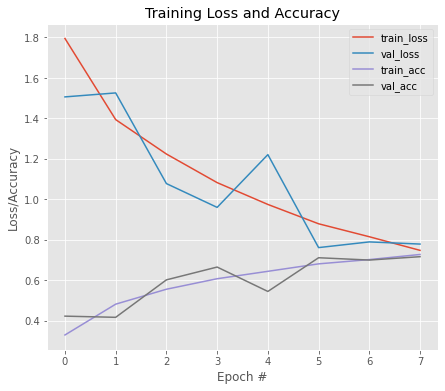


Model Performance Summary:

Min validation loss: 0.7611777782440186  at EPOCH: 6

Validation Accuracy:  0.7110416889190674


In [84]:
call_model(MODEL.model_4,get_basic_and_lrs_callback(),model_history= \
           g_record_v2)

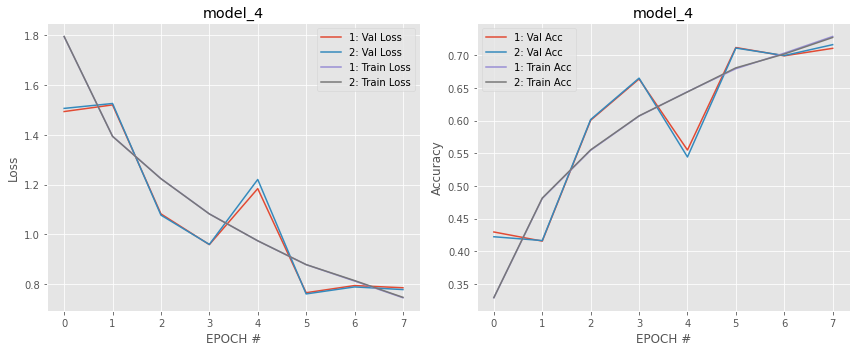

In [90]:
compare_model_performance_with_lrs("model_4")

baseLine_cnn : 0.6797916889190674
model_1 : 0.7097916603088379
model_2 : 0.7181249856948853
model_3 : 0.7212499976158142
model_4 : 0.7162500023841858


,Model,Val Acc
0,baseLine_cnn,0.679792
1,model_1,0.709792
2,model_2,0.718125
3,model_3,0.721250
4,model_4,0.716250


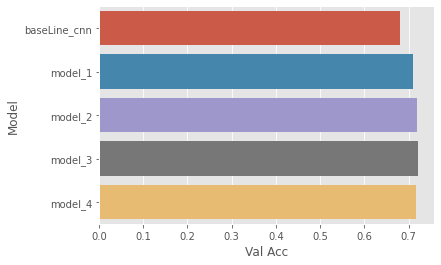

In [93]:
model_perfromance_summary_with_varying_learning_rate()

In [91]:
!nvidia-smi

Fri Apr 30 01:16:49 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 461.33       Driver Version: 461.33       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro T2000 wi... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   40C    P8     1W /  N/A |   3019MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [92]:
gc.collect()

29080